### Project Chicago: Transform ResStock UPGRADE Results to 15 SFD prototypes (Elevate Energy)
Created on: 12/15/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '03_2018' # <----- options: '03', '03_2018', '03_2019'
iter_path = f'cookcnty_upgrades_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir,iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Result path: \n   {result_path}')


Result path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_2018


### Functions

In [3]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui', 'elec_eui', 'site_eui'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui','elec_eui','site_eui']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
        
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')


func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


### 1. BASELINE results

In [4]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

# save a copy at bldg level
if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)

# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,246)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {16777-len(res)} buildings ({((16777-len(res))/16777*100):.2f}%)')

res

- 0 jobs missing: set()
- 0 buildings (0.00%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui
0,1,99,2021-02-18 20:19:46,2021-02-18 20:21:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.636364,18.272727,19.410874,14.880237,6305.0,20.704598,885.0,1.051915,11.754795,145.275409
1,2,110,2021-02-18 19:21:11,2021-02-18 19:22:51,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.090909,18.545455,16.658183,8.931701,4339.0,17.502548,3301.0,0.420159,3.195929,52.910857
2,3,18,2021-02-18 18:11:04,2021-02-18 18:12:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.363636,17.909091,14.610961,11.029130,5752.0,16.195348,1690.0,0.628635,4.556410,78.395647
3,4,169,2021-02-18 18:36:52,2021-02-18 18:38:21,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.454545,18.545455,12.034856,9.403527,6619.0,14.203674,2176.0,0.533345,4.869902,69.938527
4,5,73,2021-02-18 21:02:03,2021-02-18 21:03:28,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.000000,15.727273,15.679660,26.443951,42.0,29.539492,1690.0,0.000000,11.124041,37.956773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,150,2021-02-18 20:40:49,2021-02-18 20:42:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,13.545455,15.636364,30.550597,18.819054,4046.0,35.366833,2176.0,0.708284,4.518917,86.230672
16773,16774,124,2021-02-18 21:33:17,2021-02-18 21:34:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,16.000000,18.484782,12.510682,3521.0,21.388907,1220.0,1.615008,9.027883,192.266725
16774,16775,168,2021-02-18 18:23:58,2021-02-18 18:25:22,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.545455,17.000000,16.942458,7.623428,6159.0,18.317508,1690.0,1.257409,5.332365,143.905682
16775,16776,185,2021-02-18 22:28:05,2021-02-18 22:29:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,18.636364,31.754800,13.522137,3496.0,33.486945,8194.0,0.409924,2.465280,49.394501


In [5]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [6]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_upgrades_03_2018 - BASELINE result summary:

  * 16753 / 16777 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.669134
2            0.305199
3            0.025667
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.544858
WoodStud     0.455142
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.357548
1960-79      0.265147
1980-99      0.100937
2000-09      0.044589
2010s        0.006447
<1940        0.225333
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.828687
Heat Pump      0.006029
None           0.010923
Room AC        0.154360
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASH

### 1.2. Add additional metrics to Baseline

In [7]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories
0,1,99,2021-02-18 20:19:46,2021-02-18 20:21:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,19.410874,14.880237,6305.0,20.704598,885.0,1.051915,11.754795,145.275409,2: 1942-1978,1: <2 stories
1,2,110,2021-02-18 19:21:11,2021-02-18 19:22:51,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.658183,8.931701,4339.0,17.502548,3301.0,0.420159,3.195929,52.910857,3: post-1978,2: 2+ stories
2,3,18,2021-02-18 18:11:04,2021-02-18 18:12:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.610961,11.029130,5752.0,16.195348,1690.0,0.628635,4.556410,78.395647,3: post-1978,2: 2+ stories
3,4,169,2021-02-18 18:36:52,2021-02-18 18:38:21,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.034856,9.403527,6619.0,14.203674,2176.0,0.533345,4.869902,69.938527,2: 1942-1978,1: <2 stories
4,5,73,2021-02-18 21:02:03,2021-02-18 21:03:28,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.679660,26.443951,42.0,29.539492,1690.0,0.000000,11.124041,37.956773,3: post-1978,1: <2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,150,2021-02-18 20:40:49,2021-02-18 20:42:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.550597,18.819054,4046.0,35.366833,2176.0,0.708284,4.518917,86.230672,1: pre-1942,2: 2+ stories
16773,16774,124,2021-02-18 21:33:17,2021-02-18 21:34:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.484782,12.510682,3521.0,21.388907,1220.0,1.615008,9.027883,192.266725,1: pre-1942,2: 2+ stories
16774,16775,168,2021-02-18 18:23:58,2021-02-18 18:25:22,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.942458,7.623428,6159.0,18.317508,1690.0,1.257409,5.332365,143.905682,1: pre-1942,2: 2+ stories
16775,16776,185,2021-02-18 22:28:05,2021-02-18 22:29:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,31.754800,13.522137,3496.0,33.486945,8194.0,0.409924,2.465280,49.394501,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [8]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [9]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [10]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [11]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,743.416098,818.056843,0.370483,0.402608,8849.199166,9859.232027,4.234868,4.852204
2,Masonry All Years Split Level,1690.0,2000.196867,1068.750169,1189.140854,0.639281,0.681561,9226.091316,10543.787384,5.418507,6.152248
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1228.772790,1264.636048,0.360767,0.389177,11785.474729,13569.017078,3.549990,4.013674
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,957.778499,1049.233716,0.634843,0.669055,8702.677046,9688.837099,5.627652,6.338566
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1473.671021,1549.841266,0.706613,0.730306,10484.913794,12115.313186,5.015956,5.861211
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1263.355774,1328.278249,0.946699,0.983383,8995.357476,10005.289603,6.876232,7.471047
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1700.517383,1836.033921,0.807645,0.846786,11189.186488,13528.670572,5.319521,6.413793
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,784.544439,854.662650,0.414355,0.440535,8790.939578,9856.512740,4.598634,5.138054
9,Frame Post-1978 Split Level,2176.0,3012.053452,1007.761171,1123.593693,0.428150,0.447317,9900.989125,11761.030060,4.066374,4.717621


In [12]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_2018/baseline


## Upgrades Adjustment

In [13]:
### (1) rename upgrade
n = 72 # <----

print('rename upgrade')
p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))

upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
if upgrade_name == 'Plug Loads 25% Reduction':
    p['apply_upgrade.upgrade_name'] = 'Plug Loads 50% Reduction'
    
# show
display(p)

# save
p.to_parquet(os.path.join(result_path,'upgrades',
                                 f'upgrade={n}/results_up{n:02d}.parquet'))
print(f'>> upgrade={str(n).zfill(2)} parquet file updated and saved\n')
    

rename upgrade


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,132,2021-02-01 06:15:15,2021-02-01 06:17:11,Success,True,Plug Loads 50% Reduction,,True,20.0,...,10.653892,3.023099,1.481611,1.829559,16.909091,18.454545,17.532613,13.788719,4697.0,19.338035
1,2,211,2021-02-01 07:09:49,2021-02-01 07:12:00,Success,True,Plug Loads 50% Reduction,,True,20.0,...,7.203980,1.787854,2.223642,1.337015,16.090909,18.636364,15.636346,8.451947,4793.0,16.381472
2,3,180,2021-02-01 04:18:28,2021-02-01 04:20:19,Success,True,Plug Loads 50% Reduction,,True,20.0,...,6.066257,1.484199,1.723648,1.130652,16.090909,18.090909,13.588528,10.531675,4742.0,17.507659
3,4,217,2021-02-01 07:08:57,2021-02-01 07:10:43,Success,True,Plug Loads 50% Reduction,,True,20.0,...,5.504250,1.888895,1.833145,1.734012,14.454545,18.909091,9.525117,7.427874,4747.0,10.067185
4,5,220,2021-02-01 06:59:31,2021-02-01 07:01:22,Success,True,Plug Loads 50% Reduction,,True,20.0,...,9.953379,2.112613,7.142053,1.796210,16.272727,12.545455,15.031819,29.621641,618.0,32.450795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,30,2021-02-01 07:00:10,2021-02-01 07:02:04,Success,True,Plug Loads 50% Reduction,,True,20.0,...,8.861059,1.038141,1.463756,0.801694,15.000000,16.363636,26.356872,18.013584,5176.0,29.446628
16773,16774,41,2021-02-01 04:23:37,2021-02-01 04:25:28,Success,True,Plug Loads 50% Reduction,,True,20.0,...,6.915905,1.962381,1.771007,1.692453,15.272727,16.090909,16.059990,10.970885,4743.0,19.742043
16774,16775,123,2021-02-01 07:18:08,2021-02-01 07:19:59,Success,True,Plug Loads 50% Reduction,,True,20.0,...,8.574735,1.514128,0.937467,1.050481,15.545455,17.000000,15.821006,7.179685,5008.0,16.512530
16775,16776,152,2021-02-01 06:21:55,2021-02-01 06:23:59,Success,True,Plug Loads 50% Reduction,,True,20.0,...,14.212132,9.308463,1.644133,2.377886,16.090909,18.727273,29.836191,12.644212,4982.0,31.575884


>> upgrade=72 parquet file updated and saved



In [14]:
### (2) recalculate MSHP upgrade costs: (using filter 'hvac_has_ducts'=='No')
upgrades_to_modify = [29, # Room AC to Heat Pump
                      36, # Non-ducted Electric to MSHP
                      37, # Non-ducted Non-electric to MSHP
                     ] # <----

print("recalculate MSHP upgrade costs: (using filter 'hvac_has_ducts'=='No'")
for n in upgrades_to_modify:
    p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))

    # rename orig upgrade_cost col
    if not 'simulation_output_report.upgrade_cost_usd_orig' in p.columns:
        p['simulation_output_report.upgrade_cost_usd_orig'] = p['simulation_output_report.upgrade_cost_usd']

    # copy upgrade_cost col
    p['simulation_output_report.upgrade_cost_usd'] = p['simulation_output_report.upgrade_cost_usd_orig']

    # recalc upgrade costs for MSHP
    idx = (p['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd'] = \
        710 + (95+1800/12)*p.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

    # calculate backup heating system size and cost
    supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
    p['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
    p.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
        p.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

    p['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
        supp_heat_cost * p.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

    # add backup heat cost to 'upgrade_cost_usd'
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
        p.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']
        
    # show
    print(f'>> upgrade={str(n).zfill(2)} modified cols:')
    display(p.loc[idx, ['apply_upgrade.upgrade_name',
                        'simulation_output_report.upgrade_cost_usd_orig',
                        'simulation_output_report.upgrade_cost_usd', # updated
                        'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                        'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                       ]])


    # save
    p.to_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    p.to_csv(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.csv'), index=False)
    print(f'>> upgrade={str(n).zfill(2)} parquet file updated and saved, also exported as csv\n')
    

recalculate MSHP upgrade costs: (using filter 'hvac_has_ducts'=='No'
>> upgrade=29 modified cols:


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
15,Room AC to Heat Pump,8485.54,19854.326148,3733.826148,98.258583
18,Room AC to Heat Pump,5986.90,12886.841317,3209.841317,84.469508
19,Room AC to Heat Pump,8605.14,20116.532607,3687.332607,97.035069
20,Room AC to Heat Pump,5190.95,9824.493552,2200.593552,57.910357
23,Room AC to Heat Pump,4671.16,8689.728919,2405.978919,63.315235
...,...,...,...,...,...
16750,Room AC to Heat Pump,4713.09,8108.865218,1717.315218,45.192506
16763,Room AC to Heat Pump,5114.43,9988.944984,2561.044984,67.395921
16773,Room AC to Heat Pump,7226.72,16156.568787,3282.318787,86.376810
16774,Room AC to Heat Pump,5835.22,12250.760019,2965.760019,78.046316


>> upgrade=29 parquet file updated and saved, also exported as csv

>> upgrade=36 modified cols:


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
20,Non-ducted Electric to MSHP,5190.95,9824.493552,2200.593552,57.910357
25,Non-ducted Electric to MSHP,6205.98,13705.567030,3462.617030,91.121501
53,Non-ducted Electric to MSHP,4429.97,7043.619495,1382.169495,36.372881
225,Non-ducted Electric to MSHP,4447.81,7006.731495,1298.731495,34.177145
407,Non-ducted Electric to MSHP,5498.56,10557.313289,2139.613289,56.305613
...,...,...,...,...,...
16154,Non-ducted Electric to MSHP,4079.03,5717.963376,960.563376,25.277984
16264,Non-ducted Electric to MSHP,6092.59,12121.389334,2172.439334,57.169456
16288,Non-ducted Electric to MSHP,5031.71,9498.089147,2285.789147,60.152346
16372,Non-ducted Electric to MSHP,6431.16,14056.585879,3232.985879,85.078576


>> upgrade=36 parquet file updated and saved, also exported as csv

>> upgrade=37 modified cols:


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
15,Non-ducted Non-electric to MSHP,8485.54,19854.326148,3733.826148,98.258583
18,Non-ducted Non-electric to MSHP,5986.90,12886.841317,3209.841317,84.469508
19,Non-ducted Non-electric to MSHP,8605.14,20116.532607,3687.332607,97.035069
23,Non-ducted Non-electric to MSHP,4671.16,8689.728919,2405.978919,63.315235
27,Non-ducted Non-electric to MSHP,5043.95,9281.441188,2037.291188,53.612926
...,...,...,...,...,...
16750,Non-ducted Non-electric to MSHP,4713.09,8108.865218,1717.315218,45.192506
16763,Non-ducted Non-electric to MSHP,5114.43,9988.944984,2561.044984,67.395921
16773,Non-ducted Non-electric to MSHP,7226.72,16156.568787,3282.318787,86.376810
16774,Non-ducted Non-electric to MSHP,5835.22,12250.760019,2965.760019,78.046316


>> upgrade=37 parquet file updated and saved, also exported as csv



## 2. UPGRADE results ###

In [13]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(p, ref, HVAC_upgrades_rate_change):
    
    res = ref.set_index('building_id').reindex(p['building_id']).reset_index()
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    
    if n in HVAC_upgrades_rate_change.keys():
        new_rates = HVAC_upgrades_rate_change[n]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
        
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan
    
    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [14]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm


### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    25: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 15 ASHP
    26: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 22 ASHP
    29: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Room AC to Heat Pump
#     32: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Cooling to MSHP
    30: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar 96% AFUE Natural Gas Furnace
    31: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar Natural Gas Boiler
    33: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, High Eff
    34: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, Min Eff
    36: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Electric to MSHP
    37: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Non-electric to MSHP
    38: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, High Eff
    39: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, Min Eff
#     43: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Heating to MSHP
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed
 
# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [15]:
## make dictionary of upgrades paths, for mapping reference scenarios ##

res_partitions = ['03',] # <------
print(f'>>> {iter_path[:]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## get summary table
upgrades_path_df = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
            
        ### add to summary table
        summ = pd.DataFrame()
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            summ.loc[0,'upgrade_no'] = ni
        else:
            summ.loc[0,'upgrade_no'] = np.nan
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'partition'] = part
        summ.loc[0,'partition_upgrade_no'] = n
        upgrades_path_df.append(summ)
        
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            ni += 1
        
upgrades_path_df = pd.concat(upgrades_path_df, axis=0).reset_index(drop=True).set_index(['upgrade_name'])
print('mapping dictionary:')
upgrades_path_df


>>> cookcnty_upgrades_03_2018 has 1 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_03 has 74 upgrades
mapping dictionary:


,upgrade_no,partition,partition_upgrade_no
upgrade_name,,,
"Air Leakage 25% Reduction, with Mech Vent under 7 ACH50",1.0,03,1.0
"Air Leakage to 1ACH50, with Mech Vent",2.0,03,2.0
"Attic Insulation, R-49",3.0,03,3.0
"Attic Insulation, R-60",4.0,03,4.0
"Duct Sealing and Insulation to R-8, 10% Leakage",5.0,03,5.0
...,...,...,...
EnergyStar Dishwasher,54.0,03,70.0
"EnergyStar Dishwasher, Most Eff",55.0,03,71.0
Plug Loads 50% Reduction,56.0,03,72.0


### 2.1. Get UPGRADE summary

In [16]:
res_partitions = ['03',] # <------

export_all_upgrades_to_csv = False # <------

print(f'>>> {iter_path} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')    
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)
    

## get summary table
summary_upgrades = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        ### get sim output at unit level
        p = get_per_unit_sim_output_limited(p, res)
        
        ### assign utility rates
        p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

        ### collapse upgrade cost and lifetime cols
        p = combine_upgrade_cost_and_lifetime(p)
        
        ### check if upgrade has 0 successful sims
        if len(p[p['completed_status']=='Success']) == 0:
            print(f' * upgrade={n} has 0 successful simulations')

        ### calculate metrics
        p = add_sqft_eui(p, res)
        for var in ['gas_eui','elec_eui','site_eui']:
            p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

        # annual kBtu saved per upgrade cost:
        p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                p['upgrade_cost'], axis=0)*1000 
        
        # annual energy saving:
        p = get_annual_gas_elec_site_energy_saving(p, res)
                                                   
        # annual energy cost saving:
        p = get_annual_energy_cost_saving(p, res)
        
        # simple payback
        p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']
        
        # comparative payback ###
        p['comparative_payback'] = np.nan
        has_comparative_payback = False
        ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
        if ref_name != '':
            has_comparative_payback = True
            print(f'  - has ref scenario: {ref_name}')
            ref_info = upgrades_path_df.loc[ref_name]
            
            # load ref scenario:
            iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
            n_ref = int(ref_info['partition_upgrade_no'])
            
            ref_path = os.path.join(result_dir,iterpath)
            refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                         f'upgrade={n_ref}/results_up{n_ref:02d}.parquet'))
            
            # get sim output at unit level
            refp = get_per_unit_sim_output_limited(refp, res)
        
            # assign utility rates
            refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)
            
            # collapse upgrade cost and lifetime cols
            refp = combine_upgrade_cost_and_lifetime(refp)
            
            # annual energy cost saving:
            ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)
            
            # update comparative payback
            p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

        # annual metric ton carbon emission savings:
        p = get_annual_metric_ton_co2e_saving(p, res)
        
        ### check for neg/large paybacks, inf eui, neg carbon savings
        print_metrics_report(p, has_comparative_payback)

        ### subset to only those that have been applied with the upgrades successfully:
        p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
   
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            upgrade_no = ni
        else:
            upgrade_no = np.nan
        p['upgrade_no'] = upgrade_no

        ### export upgrade results to csv 
        if export_all_upgrades_to_csv:
            p.to_csv(os.path.join(combined_res_csv_path, f'results_up{nf}{fn_ext}.csv'), index=False)

        for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
            p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

        ### add to summary table
        summ = pd.DataFrame()
        summ.loc[0,'upgrade_no'] = upgrade_no
        summ.loc[0,'run_no'] = part
        summ.loc[0,'run_upgrade_no'] = n
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'n_applied'] = len(p)
        summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
        summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
        summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

        p = p[p['completed_status']=='Success'].reset_index(drop=True)
        summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
        summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
        summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
        summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
        summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
        summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
        summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
        summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
        summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
        summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)
        
        summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
        
        p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
        summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
        summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

         # filter: min 10 cent energy cost savings **
        min_energy_cost_saving = 0.1 # <----- **
        summ['pct_pos_simple_payback_filtered'] = round(len(
            p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
        )/len(p)*100, 3)
        summ['mean_pos_simple_payback_filtered'] = round(
            p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
               'simple_payback'].mean(),3)

        n_cp = len(p[~p['comparative_payback'].isnull()])
        if ref_name != '' and n_cp>0:   
            summ['median_comparative_payback'] = round(p['comparative_payback'].median(),3)
            
            p['comparative_payback'] = p['comparative_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
            summ['pct_pos_comparative_payback_actual'] = round(len(p[p['comparative_payback']>=0])/n_cp*100, 3)
            summ['mean_pos_comparative_payback_actual'] = round(p.loc[p['comparative_payback']>=0, 'comparative_payback'].mean(), 3)
            
            # filter: min 10 cent energy cost savings **
            summ['pct_pos_comparative_payback_filtered'] = round(len(
                p[(p['comparative_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
            )/len(p)*100, 3)
            summ['mean_pos_comparative_payback_filtered'] = round(
                p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
                   'comparative_payback'].mean(),3)
        else:
            summ['median_comparative_payback'] = np.nan
            summ['pct_pos_comparative_payback_actual'] = np.nan
            summ['mean_pos_comparative_payback_actual'] = np.nan
            summ['pct_pos_comparative_payback_filtered'] = np.nan # **
            summ['mean_pos_comparative_payback_filtered'] = np.nan # **
            
        summary_upgrades.append(summ)
        
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            ni += 1
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_upgrades_03_2018 has 1 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_03 has 74 upgrades

Upgrade 1 (03.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -39686.558776
median       18.657404
max       19007.456953
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 275 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 1151 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 1327 carbon saving<0 

Upgrade 2 (03.2): Air Leakage to 1ACH50, with Mech Vent
min       -58956.072180
median        26.874183
max       129940.355714
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 1673 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 1078 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 1271 carbon saving<0 

Upgrade 3 (03.3): Attic Insulation, R-49
min 

min      -2.654869e+06
median    7.748444e+01
max       1.354235e+06
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=22 has 5477 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=22 has 2498 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=22 has 4622 carbon saving<0 

Upgrade 21 (03.23): SEER 18 CAC
  - has ref scenario: Reference AC, SEER 15
min      -449868.451931
median        65.220643
max       118071.437539
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=23 has 4472 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=23 has 1721 simple_payback<0 (due to negative energy cost saving)
min      -142710.215326
median        15.695812
max        84253.435201
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=23 has 617 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=23 has 2670 comparative_payback<0 (due 

  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min      -200376.167286
median       -12.824430
max        89540.298890
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=38 has 1059 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=38 has 8446 simple_payback<0 (due to negative energy cost saving)
min       -14429.315259
median        -6.551963
max       823062.626843
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=38 has 24 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=38 has 11333 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=38 has 10901 carbon saving<0 

Upgrade 34 (03.39): Non-electric Furnace to Heat Pump, Min Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min      -154720.14734
median        -9.69907
max        55913.14834
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=39 has

  - has ref scenario: Reference Fuel Clothes Dryer
min      -61214.036461
median      -17.525231
max       26505.269547
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=51 has 515 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=51 has 11052 simple_payback<0 (due to negative energy cost saving)
min             -inf
median      4.383819
max       111.267009
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=51 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=51 has 17 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=51 has 11808 carbon saving<0 

Upgrade 43 (03.52): Non-electric Clothes Dryer to HPCD
  - has ref scenario: Reference Fuel Clothes Dryer
min      -473800.989493
median       -36.489927
max       162546.419411
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=52 has 1093 simple_payback>100 (including 0 INF)


min      -221660.478787
median        19.263081
max        84757.261916
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=66 has 1842 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=66 has 5104 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=66 has 9470 carbon saving<0 

Upgrade 52 (03.67): EnergyStar Clothes Washer
  - has ref scenario: Reference Clothes Washer
min      -195366.880926
median        15.904318
max       485535.735053
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=67 has 223 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=67 has 661 simple_payback<0 (due to negative energy cost saving)
min       1.168150
median    6.750478
max            inf
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=67 has 3 comparative_payback>100 (including 1 INF)
    *CARBON - negative*  upgrade=67 has 1327 carbon saving<0 

Upgrade 53

,upgrade_no,run_no,run_upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,...,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered,median_comparative_payback,pct_pos_comparative_payback_actual,mean_pos_comparative_payback_actual,pct_pos_comparative_payback_filtered,mean_pos_comparative_payback_filtered
0,1.0,03,1.0,"Air Leakage 25% Reduction, with Mech Vent unde...",16753.0,16746.0,0.0,99.958,12.525,694.827,...,18.657,93.127,35.067,93.121,33.850,NaN,NaN,NaN,NaN,NaN
1,2.0,03,2.0,"Air Leakage to 1ACH50, with Mech Vent",16753.0,16753.0,0.0,100.000,235.581,882.982,...,26.874,93.565,79.407,93.559,71.122,NaN,NaN,NaN,NaN,NaN
2,3.0,03,3.0,"Attic Insulation, R-49",16753.0,15365.0,0.0,91.715,10.186,867.778,...,22.314,90.582,84.088,90.550,47.454,NaN,NaN,NaN,NaN,NaN
3,4.0,03,4.0,"Attic Insulation, R-60",16753.0,16753.0,0.0,100.000,8.102,856.436,...,30.402,91.190,158.187,91.148,64.679,NaN,NaN,NaN,NaN,NaN
4,5.0,03,5.0,"Duct Sealing and Insulation to R-8, 10% Leakage",16753.0,8907.0,0.0,53.167,-51.663,767.056,...,15.693,91.950,1071.448,91.928,44.822,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,54.0,03,70.0,EnergyStar Dishwasher,16753.0,2886.0,0.0,17.227,-94.635,569.976,...,30.626,77.062,136.745,76.958,108.488,20.782,100.0,22.941,76.958,22.732
70,55.0,03,71.0,"EnergyStar Dishwasher, Most Eff",16753.0,7361.0,0.0,43.938,-95.571,569.694,...,36.874,75.438,282.698,75.316,144.332,55.726,100.0,63.137,75.316,61.810
71,56.0,03,72.0,Plug Loads 50% Reduction,16753.0,16753.0,0.0,100.000,-126.547,2059.595,...,1.791,97.201,3.096,97.189,2.412,NaN,NaN,NaN,NaN,NaN
72,57.0,03,73.0,"Rooftop Solar, 4 kW",16753.0,16753.0,0.0,100.000,-98.761,5618.549,...,18.420,99.982,18.953,99.982,18.953,NaN,NaN,NaN,NaN,NaN


In [31]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results


In [26]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
n = 25 # <----- number or 'bl'

if save_to_csv:
    if n in ['baseline', 'bl', 0]:
        p = pd.read_parquet(os.path.join(result_path,'baseline',
                                     'results_up00.parquet'))
        p.to_csv(os.path.join(result_path,'baseline',
                                         'results_up00.csv'), index=False)
        print(f'baseline parquet file exported as csv')
        
    else:
        nf = f'0{n}' if n<10 else n
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.csv'), index=False)
        print(f'upgrade {nf} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [80]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = []
    
ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0 # <------
    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

    ### (3) add upgrades results
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        if upgrade_name.startswith('Reference'):
            print(f'  - is a reference scenario, skipping')
            
#         elif upgrade_name == 'EnergyStar Refrigerator':
#             print(f'  - is EnergyStar Refrigerator, skipping')
            
        else:
            ### get sim output at unit level
#             p = get_per_unit_sim_output_limited(p, res) # this is slow, ignore here b/c only sfd is used
        
            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)
            
            ### add totals metrics:
            p = get_annual_totals(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations\n')

            ### calculate metrics 
            p = add_sqft_eui(p, res)
            for var in ['gas_eui','elec_eui','site_eui']:
                p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                    p['upgrade_cost'])*1000 

            # annual energy saving:
            p = get_annual_gas_elec_site_energy_saving(p, res)
            
            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res)

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            has_comparative_payback = False
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                has_comparative_payback = True
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))
                
                # get sim output at unit level
#                 refp = get_per_unit_sim_output_limited(refp, res) # slow, ignore here b/c only sfd is used
                
                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg/large paybacks, inf eui, neg carbon savings 
            print_metrics_report(p, has_comparative_payback)
            p['upgrade_no'] = ni
            
            ### get results by prototype
            for i, row in groups.iterrows():
                if row['HousingGroupName'] not in \
                ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
                    pi = get_res_by_prototype(p, res, row) # <----

                    ### subset to only those that have been applied with the upgrades successfully:
                    pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
                    
                    pi['HousingGroupNo'] = row["HousingGroupNo"]
                    pi['HousingGroupName'] = row["HousingGroupName"]
                    all_proto_upgrades.append(pi)
            
            ni += 1

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 3

 >> cookcnty_upgrades_03 has 74 upgrades

Upgrade 1 (03.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -1.210994e+06
median    8.299963e+00
max       5.212832e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 199 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 1149 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 1296 carbon saving<0 

Upgrade 2 (03.2): Air Leakage to 1ACH50, with Mech Vent
min      -411272.720249
median        10.359194
max        36617.317559
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 527 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 1177 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 1439 carbon saving<0 

Upgrade 3 (03.3): Attic Insulation, R-49
min            1.488420
median        18.705989
max 


Upgrade 22 (03.24): SEER 24.5 CAC
  - has ref scenario: Reference AC, SEER 15
min         7.506700
median     44.849628
max       491.467766
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=24 has 872 simple_payback>100 (including 0 INF)
min        -1.192322
median     13.041737
max       323.655592
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=24 has 7 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=24 has 5 comparative_payback<0 (due to negative energy cost saving)

Upgrade 23 (03.25): CAC to SEER 15 ASHP
  - has ref scenario: Reference AC, SEER 15
min      -3431.611308
median       7.880685
max       7775.274786
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=25 has 47 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=25 has 288 simple_payback<0 (due to negative energy cost saving)
min       -5606.218938
median        1.978698
max       57656.256584
Name:


Upgrade 36 (03.42): NG Tankless Water Heater
  - has ref scenario: Reference Gas Water Heater
min       -16060.099674
median        20.553902
max       433302.967199
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=42 has 50 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=42 has 64 simple_payback<0 (due to negative energy cost saving)
min      -1836.914753
median      21.124077
max       8474.401504
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=42 has 89 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=42 has 3 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=42 has 105 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=42 has 120 carbon saving<0 

Upgrade 37 (03.43): Reference Electric Water Heater
  - is a reference scenario, skipping

Upgrade 37 (03.44): Electric Water Heater to 50 gal HPWH
  - has


Upgrade 48 (03.60): Reference Electric Cooking
  - is a reference scenario, skipping

Upgrade 48 (03.61): Electric Cooking to Induction
  - has ref scenario: Reference Electric Cooking
min       -593.193932
median     289.423090
max       1568.785189
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=61 has 5313 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=61 has 1902 simple_payback<0 (due to negative energy cost saving)
min      -305.963186
median    149.341345
max       809.288868
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=61 has 4214 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=61 has 1902 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=61 has 1902 carbon saving<0 

Upgrade 49 (03.62): LED
min         2.548576
median      9.217086
max       120.311431
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=62 h

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,HousingGroupNo,HousingGroupName,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,69,165,2021-02-01 04:57:24,2021-02-01 04:59:19,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,1.994526,0.561367,2.555893,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
1,74,154,2021-02-01 07:00:37,2021-02-01 07:02:31,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.254128,0.055102,0.309231,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
2,104,173,2021-02-01 07:14:17,2021-02-01 07:16:11,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,1.325215,0.294281,1.619496,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
3,130,24,2021-02-01 06:51:02,2021-02-01 06:52:56,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.625590,0.195507,0.821097,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
4,150,106,2021-02-01 04:45:14,2021-02-01 04:47:11,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.376505,0.052498,0.429002,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570179,16750,175,2021-02-01 06:43:37,2021-02-01 06:45:36,Success,True,Smart Thermostat,,True,20.0,...,NaN,0.172993,0.002031,0.175023,58,15,Frame Pre-1942 2 or more stories,NaN,NaN,NaN
570180,16758,187,2021-02-01 07:37:57,2021-02-01 07:40:19,Success,True,Smart Thermostat,,True,20.0,...,NaN,0.105365,0.137986,0.243351,58,15,Frame Pre-1942 2 or more stories,NaN,NaN,NaN
570181,16759,200,2021-02-01 07:08:49,2021-02-01 07:10:48,Success,True,Smart Thermostat,,True,20.0,...,NaN,0.000000,0.000000,0.000000,58,15,Frame Pre-1942 2 or more stories,NaN,NaN,NaN
570182,16769,88,2021-02-01 07:51:15,2021-02-01 07:53:49,Success,True,Smart Thermostat,,True,20.0,...,NaN,0.319686,0.055299,0.374985,58,15,Frame Pre-1942 2 or more stories,NaN,NaN,NaN


In [81]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))

cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,HousingGroupNo,HousingGroupName,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,69,165,2021-02-01 04:57:24,2021-02-01 04:59:19,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,1.994526,0.561367,2.555893,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
1,74,154,2021-02-01 07:00:37,2021-02-01 07:02:31,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.254128,0.055102,0.309231,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
2,104,173,2021-02-01 07:14:17,2021-02-01 07:16:11,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,1.325215,0.294281,1.619496,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
3,130,24,2021-02-01 06:51:02,2021-02-01 06:52:56,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.625590,0.195507,0.821097,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
4,150,106,2021-02-01 04:45:14,2021-02-01 04:47:11,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,20.0,...,NaN,0.376505,0.052498,0.429002,1,1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586932,16773,223,2021-02-01 06:40:37,2021-02-01 06:42:05,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,0,15,Frame Pre-1942 2 or more stories,NaN,NaN,NaN
586933,16774,114,2021-02-01 07:28:01,2021-02-01 07:29:26,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN,NaN,NaN
586934,16775,106,2021-02-01 06:25:13,2021-02-01 06:26:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN,NaN,NaN
586935,16776,175,2021-02-01 05:05:59,2021-02-01 05:07:43,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN,NaN,NaN


In [82]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status',
                        'upgrade_no','HousingGroupNo','HousingGroupName']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)
    
    print('"res_proto_meta" df saved')
    display(res_proto_meta)


### 2.2. Get UPGRADE results by SFD building prototypes from Elevate Energy

In [32]:
res_partitions = ['03',] # <------

combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui',
               'mean_elec_eui kwh_per_sqft': 'elec_eui',
               'mean_site_eui kbtu_per_sqft': 'site_eui'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

    ### (3) add upgrades results
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
            
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        if upgrade_name.startswith('Reference'):
            print(f'  - is a reference scenario, skipping')
            
#         elif upgrade_name == 'EnergyStar Refrigerator':
#             print(f'  - is EnergyStar Refrigerator, skipping')
            
        else:
            ### get sim output at unit level
#             p = get_per_unit_sim_output_limited(p, res) # this is slow, ignore here b/c only sfd is used
        
            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations\n')

            ### calculate metrics 
            p = add_sqft_eui(p, res)
            for var in ['gas_eui','elec_eui','site_eui']:
                p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                    p['upgrade_cost'])*1000 

            # annual energy saving:
            p = get_annual_gas_elec_site_energy_saving(p, res)
            
            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res)

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            has_comparative_payback = False
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                has_comparative_payback = True
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{str(n_ref).zfill(2)}.parquet'))
                
                # get sim output at unit level
#                 refp = get_per_unit_sim_output_limited(refp, res) # slow, ignore here b/c only sfd is used
                
                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg/large paybacks, inf eui, neg carbon savings 
            print_metrics_report(p, has_comparative_payback)
            p['upgrade_no'] = ni
            
            ### get results by prototype
            for i, row in chars_to_map.iterrows():
                pi = get_res_by_prototype(p, res, row) # <----
                
                ### subset to only those that have been applied with the upgrades successfully:
                pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

                if combine_all_upgrades_and_export_as_csv:
                    pi['HousingGroupNo'] = row["HousingGroupNo"]
                    pi['HousingGroupName'] = row["HousingGroupName"]
                    all_proto_upgrades.append(pi)

                for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups2.loc[i, ((f'mean_{var}'),(f'upg{ni:02d}'))] = round(pi[var].mean(), 3)
                for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups2.loc[i, ((f'mean_{var}'),(f'upg{ni:02d}'))] = round(pi[var].mean(), 2)
                for var in ['simple_payback','comparative_payback']:
                    n_cp = len(pi[~pi[var].isnull()])
                    if ref_name != '' and n_cp>0:
                        groups2.loc[i, ((f'median_{var}'),(f'upg{ni:02d}'))] = round(pi[var].median(), 2)
                        pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                        
                        # filter: min 1 cent energy cost savings **
                        min_energy_cost_saving = 0.1 # <----- ** 
                        groups2.loc[i, ((f'pct_pos_{var}'),(f'upg{ni:02d}'))] = round(len(
                            pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
                        )/n_cp*100, 3)
                        groups2.loc[i, ((f'mean_pos_{var}'),(f'upg{ni:02d}'))] = round(
                            pi.loc[(p[var]>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving),var].mean(), 2)
                    else:
                        groups2.loc[i, ((f'median_{var}'),(f'upg{ni:02d}'))] = np.nan
                        groups2.loc[i, ((f'pct_pos_{var}'),(f'upg{ni:02d}'))] = np.nan
                        groups2.loc[i, ((f'mean_pos_{var}'),(f'upg{ni:02d}'))] = np.nan
                    
            ni += 1

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {N_upgrades} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


>>> cookcnty_upgrades_0 has 1 partitions
Natural gas rate multiplier: 3
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777

 >> cookcnty_upgrades_03 has 74 upgrades

Upgrade 1 (03.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -1.210994e+06
median    8.299963e+00
max       5.212832e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 199 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 1149 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 1296 carbon saving<0 

Upgrade 2 (03.2): Air Leakage to 1ACH50, with Mech Vent
min      -411272.720249
median        10.359194
max        36617.317559
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 527 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 1177 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 10 (03.11): Drill-and-fill Insulation for Wood Wall
min      -19663.786461
median        6.704626
max       85517.754484
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 87 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=11 has 9 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 11 carbon saving<0 

Upgrade 11 (03.12): Drill-and-fill to R-13, R-20 External XPS
min       -4057.277615
median       10.724624
max       28715.865038
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=12 has 71 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=12 has 10 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 12 carbon saving<0 

Upgrade 12 (03.13): Drill-and-fill Insulation for Wood wall and R-5 Sheathing
min      -21110.850229
median        8.971678
max       79279.043068
Name: simple_payback, dtype: float6

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 22 (03.24): SEER 24.5 CAC
  - has ref scenario: Reference AC, SEER 15
min         7.506700
median     44.849628
max       491.467766
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=24 has 872 simple_payback>100 (including 0 INF)
min        -1.192322
median     13.041737
max       323.655592
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=24 has 7 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=24 has 5 comparative_payback<0 (due to negative energy cost saving)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 23 (03.25): CAC to SEER 15 ASHP
  - has ref scenario: Reference AC, SEER 15
min      -3431.611308
median       7.880685
max       7775.274786
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=25 has 47 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=25 has 288 simple_payback<0 (due to negative energy cost saving)
min       -5606.218938
median        1.978698
max       57656.256584
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=25 has 83 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=25 has 2212 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=25 has 13543 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 24 (03.26): CAC to SEER 22 ASHP
  - has ref scenario: Reference AC, SEER 15
min      -205.192419
median      6.178526
max       138.890133
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=26 has 1 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=26 has 152 simple_payback<0 (due to negative energy cost saving)
min      -367.394465
median      3.378498
max       288.253595
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=26 has 6 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=26 has 179 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=26 has 13076 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 25 (03.27): EnergyStar Room AC
min         3.559009
median     27.900349
max       273.523380
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=27 has 51 simple_payback>100 (including 0 INF)

Upgrade 26 (03.28): Reference Room AC
  - is a reference scenario, skipping

Upgrade 26 (03.29): Room AC to Heat Pump
  - has ref scenario: Reference Room AC
min      -7812.830656
median       6.030144
max        119.109856
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=29 has 1 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=29 has 26 simple_payback<0 (due to negative energy cost saving)
min      -40.172478
median     6.985780
max       21.504786
Name: comparative_payback, dtype: float64
    *PAYBACK2 - negative*  upgrade=29 has 28 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=29 has 442 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 27 (03.30): EnergyStar 96% AFUE Natural Gas Furnace
min        -6.541033
median     11.911505
max       466.730541
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=30 has 385 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=30 has 96 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=30 has 83 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=30 has 96 carbon saving<0 

Upgrade 28 (03.31): EnergyStar Natural Gas Boiler
min        -6.049215
median     16.654417
max       326.540555
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=31 has 1 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=31 has 8 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=31 has 6 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=31 has 8 carbon saving<0 

Upgrade 29

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 30 (03.34): Electric Furnace to Heat Pump, Min Eff
  - has ref scenario: Reference Electric Furnace
min      -6.713879e+12
median    7.486341e+00
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=34 has 17 simple_payback>100 (including 5 INF)
    *PAYBACK1 - negative*  upgrade=34 has 6 simple_payback<0 (due to negative energy cost saving)
min       -2.315699
median     1.074922
max       17.567297
Name: comparative_payback, dtype: float64
    *PAYBACK2 - negative*  upgrade=34 has 39 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=34 has 6 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 31 (03.35): Reference Non-ducted Electric
  - is a reference scenario, skipping

Upgrade 31 (03.36): Non-ducted Electric to MSHP
  - has ref scenario: Reference Non-ducted Electric
min        3.388902
median     5.921346
max       12.816899
Name: simple_payback, dtype: float64
min       2.273987
median    4.391031
max       9.619283
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 32 (03.37): Non-ducted Non-electric to MSHP
  - has ref scenario: Reference Non-ducted Electric
min      -261.634320
median      6.175215
max       119.109856
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=37 has 1 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=37 has 23 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=37 has 424 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 33 (03.38): Non-electric Furnace to Heat Pump, High Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min      -7812.830656
median       6.276078
max         25.062443
Name: simple_payback, dtype: float64
    *PAYBACK1 - negative*  upgrade=38 has 97 simple_payback<0 (due to negative energy cost saving)
min      -1661.071558
median       8.376011
max       8090.294520
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=38 has 40 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=38 has 98 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=38 has 10977 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 34 (03.39): Non-electric Furnace to Heat Pump, Min Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min      -4439.089819
median      10.403336
max       9683.036781
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=39 has 62 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=39 has 199 simple_payback<0 (due to negative energy cost saving)
min      -40236.782693
median       11.580806
max       39197.318253
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=39 has 902 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=39 has 5122 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=39 has 11377 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 35 (03.40): Reference Gas Water Heater
  - is a reference scenario, skipping

Upgrade 35 (03.41): Condensing NG Tank Water Heater
  - has ref scenario: Reference Gas Water Heater
min        -6882.017767
median        12.309357
max       156945.703305
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=41 has 29 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=41 has 77 simple_payback<0 (due to negative energy cost saving)
min       -33.587334
median      4.897943
max       102.571219
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=41 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=41 has 2 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=41 has 105 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=41 has 121 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 36 (03.42): NG Tankless Water Heater
  - has ref scenario: Reference Gas Water Heater
min       -16060.099674
median        20.553902
max       433302.967199
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=42 has 50 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=42 has 64 simple_payback<0 (due to negative energy cost saving)
min      -1836.914753
median      21.124077
max       8474.401504
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=42 has 89 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=42 has 3 comparative_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=42 has 105 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=42 has 120 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 37 (03.43): Reference Electric Water Heater
  - is a reference scenario, skipping

Upgrade 37 (03.44): Electric Water Heater to 50 gal HPWH
  - has ref scenario: Reference Electric Water Heater
min        -75.058153
median      18.165390
max       1511.890612
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=44 has 7 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=44 has 5 simple_payback<0 (due to negative energy cost saving)
min      -143.763394
median      9.854632
max       945.377164
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=44 has 2 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=44 has 3 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=44 has 5 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 38 (03.45): Electric Water Heater to 80 gal HPWH
  - has ref scenario: Reference Electric Water Heater
min      -3130.240621
median      24.294926
max       5500.027695
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=45 has 49 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=45 has 27 simple_payback<0 (due to negative energy cost saving)
min      -16811.084729
median       15.479288
max        4461.297605
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=45 has 37 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=45 has 28 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=45 has 27 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 39 (03.46): Non-electric Water Heater to 50 gal HPWH
  - has ref scenario: Reference Gas Water Heater
min      -168880.424503
median        23.686916
max        30346.164193
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=46 has 559 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=46 has 1224 simple_payback<0 (due to negative energy cost saving)
min      -51111.079309
median        9.274122
max       51816.563379
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=46 has 460 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=46 has 6743 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=46 has 15227 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 40 (03.47): Non-electric Water Heater to 80 gal HPWH
  - has ref scenario: Reference Gas Water Heater
min       -28090.264514
median        32.613403
max       101567.698336
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=47 has 1308 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=47 has 889 simple_payback<0 (due to negative energy cost saving)
min      -869473.994078
median        10.339098
max       336027.041208
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=47 has 1334 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=47 has 7113 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=47 has 16178 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 41 (03.48): Reference Electric Clothes Dryer
  - is a reference scenario, skipping

Upgrade 41 (03.49): Electric Clothes Dryer to HPCD
  - has ref scenario: Reference Electric Clothes Dryer
min        11.515845
median     35.503160
max       108.849879
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=49 has 17 simple_payback>100 (including 0 INF)
min        5.479954
median    16.894607
max       51.797529
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 42 (03.50): Reference Fuel Clothes Dryer
  - is a reference scenario, skipping

Upgrade 42 (03.51): Electrify Non-electric Clothes Dryer
  - has ref scenario: Reference Fuel Clothes Dryer
min      -613.776399
median    -79.057946
max              inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=51 has 13 simple_payback>100 (including 1 INF)
    *PAYBACK1 - negative*  upgrade=51 has 12590 simple_payback<0 (due to negative energy cost saving)
min             -inf
median     19.768058
max       153.444100
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=51 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=51 has 191 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=51 has 12780 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 43 (03.52): Non-electric Clothes Dryer to HPCD
  - has ref scenario: Reference Fuel Clothes Dryer
min      -1.964294e+07
median   -1.069040e+03
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=52 has 579 simple_payback>100 (including 1 INF)
    *PAYBACK1 - negative*  upgrade=52 has 12007 simple_payback<0 (due to negative energy cost saving)
min      -5.907889e+06
median   -3.317710e+02
max                inf
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=52 has 574 comparative_payback>100 (including 1 INF)
    *PAYBACK2 - negative*  upgrade=52 has 12007 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=52 has 12780 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 44 (03.53): Reference Pool Pump
  - is a reference scenario, skipping

Upgrade 44 (03.54): Efficient Pool Pump
  - has ref scenario: Reference Pool Pump
min        3.786458
median     9.142869
max       16.979327
Name: simple_payback, dtype: float64
min       0.646469
median    1.560978
max       2.898909
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 45 (03.55): Reference Pool Heating
  - is a reference scenario, skipping

Upgrade 45 (03.56): Electrify Pool Heating
  - has ref scenario: Reference Pool Heating
min        3.507726
median     7.472332
max       12.536008
Name: simple_payback, dtype: float64
min       0.146155
median    0.311347
max       0.522334
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 46 (03.57): Reference Gas Cooking
  - is a reference scenario, skipping

Upgrade 46 (03.58): Electrify Non-electric Cooking
  - has ref scenario: Reference Gas Cooking
min       -28482.789336
median      -389.978722
max       564458.984933
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=58 has 33 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=58 has 8834 simple_payback<0 (due to negative energy cost saving)
min       -3095.956059
median      -42.394980
max       61354.355506
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=58 has 23 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=58 has 8830 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=58 has 8892 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 47 (03.59): Non-electric Cooking to Induction
  - has ref scenario: Reference Gas Cooking
min      -4.098515e+06
median    1.860681e+02
max       3.257007e+06
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=59 has 5463 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=59 has 3125 simple_payback<0 (due to negative energy cost saving)
min      -2.329682e+06
median    1.059002e+02
max       1.853587e+06
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=59 has 4611 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=59 has 3116 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=59 has 8892 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 48 (03.60): Reference Electric Cooking
  - is a reference scenario, skipping

Upgrade 48 (03.61): Electric Cooking to Induction
  - has ref scenario: Reference Electric Cooking
min       -593.193932
median     289.423090
max       1568.785189
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=61 has 5313 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=61 has 1902 simple_payback<0 (due to negative energy cost saving)
min      -305.963186
median    149.341345
max       809.288868
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=61 has 4214 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=61 has 1902 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=61 has 1902 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 49 (03.62): LED
min         2.548576
median      9.217086
max       120.311431
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=62 has 20 simple_payback>100 (including 0 INF)

Upgrade 50 (03.63): Reference Refrigerator
  - is a reference scenario, skipping

Upgrade 50 (03.64): EnergyStar Refrigerator
  - has ref scenario: Reference Refrigerator
min         4.553953
median    194.814623
max       636.324255
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=64 has 11483 simple_payback>100 (including 0 INF)
min        3.753585
median     6.221402
max       20.806695
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 51 (03.65): EnergyStar Refrigerator, Most Eff
  - has ref scenario: Reference Refrigerator
min         8.954328
median    147.689832
max       495.546164
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=65 has 14010 simple_payback>100 (including 0 INF)
min        50.924693
median     84.427545
max       282.202280
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=65 has 1404 comparative_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 52 (03.66): Reference Clothes Washer
  - is a reference scenario, skipping

Upgrade 52 (03.67): EnergyStar Clothes Washer
  - has ref scenario: Reference Clothes Washer
min        4.307288
median    12.880446
max             inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=67 has 16 simple_payback>100 (including 1 INF)
min       0.957175
median    2.862321
max            inf
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=67 has 3 comparative_payback>100 (including 1 INF)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 53 (03.68): EnergyStar Clothes Washer, Most Eff
  - has ref scenario: Reference Clothes Washer
min        6.212525
median    58.543153
max             inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=68 has 2853 simple_payback>100 (including 1 INF)
min        3.727515
median    28.446629
max             inf
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=68 has 68 comparative_payback>100 (including 1 INF)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 54 (03.69): Reference Dishwasher
  - is a reference scenario, skipping

Upgrade 54 (03.70): EnergyStar Dishwasher
  - has ref scenario: Reference Dishwasher
min        40.567983
median    100.568626
max       633.875098
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=70 has 1457 simple_payback>100 (including 0 INF)
min        4.868158
median    12.068235
max       76.065012
Name: comparative_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 55 (03.71): EnergyStar Dishwasher, Most Eff
  - has ref scenario: Reference Dishwasher
min         32.680528
median     175.443359
max       1455.381551
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=71 has 5258 simple_payback>100 (including 0 INF)
min         8.714808
median     32.697504
max       242.564141
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=71 has 26 comparative_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Boolean Series key will be reindexed to m


Upgrade 56 (03.72): Plug Loads 50% Reduction
min        0.420662
median     2.556771
max       12.973589
Name: simple_payback, dtype: float64

Upgrade 57 (03.73): Rooftop Solar, 4 kW
min       18.688855
median    18.731848
max       22.041373
Name: simple_payback, dtype: float64

Upgrade 58 (03.74): Smart Thermostat
min      -6.766225e+13
median    9.692669e+00
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=74 has 4000 simple_payback>100 (including 2602 INF)
    *PAYBACK1 - negative*  upgrade=74 has 2183 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=74 has 2875 carbon saving<0 

all 74 UPGRADEs are combined and saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.437646   
1              0.019980  9128.0                    0.735932   
2              0.032967   514.0                    0.417770   
3              0.191808  5488.0                    0.723602   
4              0.045954   794.0                    0.785354   
5              0.073926   726.0                    1.061201   
6              0.021978   921.0                    0.909812   
7              0.015984   596.0                    0.480803   
8              0.021978  1347.0                    0.484157   
9              0.087912   751.0                    0.486818   
10             0.183816  3012.0                    0.762651   
11             0.064935  2128.0                    1.086637   
12             0.066933  1138.0                    0.898791   
13             0.109890   703.0                    1.168653   
14             0.048951  1425.0                    1.046176   

                               ... pct_pos_simple_payback                  \
   mean_elec_eui kwh_per_sqft  ...                  upg49   upg50   upg51   
0                    4.673625  ...                    NaN  99.854  99.854   
1                    5.833191  ...                    NaN  99.847  99.847   
2                    3.860405  ...                    NaN  99.805  99.805   
3                    6.023757  ...

In [33]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE by prototype table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE by prototype table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results


### 2.3. Get UPGRADE results for Chicago total sfd stock

In [34]:
## get mean cost, energy, and carbon emission savings
res_partitions = ['03',] # <------

print(f'>>> {iter_path[:-1]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## (1) Load prototype csv
groups3 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups3 = groups3.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups3[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

groups3.columns = pd.MultiIndex.from_product([['Baseline'], groups3.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups3.columns)

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

    ### (2) add upgrades results
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
        
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        
        if upgrade_name.startswith('Reference'):
            print(f'  - is a reference scenario, skipping')
            
#         elif upgrade_name =='EnergyStar Refrigerator':
#             print(f'  - is EnergyStar Refrigerator, skipping')
            
        else:
            ### get sim output at unit level
#             p = get_per_unit_sim_output_limited(p, res) # slow, ignore b/c only sfd is used
        
            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations\n')

            ### calculate metrics 
            # annual energy savings:
            p = get_annual_gas_elec_site_energy_saving(p, res)

            # annual energy cost savings:
            p = get_annual_energy_cost_saving(p, res)

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg carbon savings
            ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
            if len(ces_neg)>0:
                print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')        

            p['upgrade_no'] = ni
            ### get results by prototype
            for i, row in chars_to_map.iterrows():
                pi = get_res_by_prototype(p, res, row) # <----
                
                ### subset to only those that have been applied with the upgrades:
                pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

                for var in ['ann_mbtu_site_energy_saving','ann_therm_gas_saving', 'ann_kwh_elec_saving', 
                            'ann_metric_ton_co2e_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups3.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 3)
                for var in ['upgrade_cost', 'ann_gas_cost_saving','ann_elec_cost_saving']:
                    pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                    groups3.loc[i, ((f'mean_{var}'),(f'upg{str(ni).zfill(2)}'))] = round(pi[var].mean(), 2)

            ni += 1
        

# split to sort
groups_upgrades = groups3.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups3 = pd.concat([groups3.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups3


>>> cookcnty_upgrades_0 has 1 partitions
Natural gas rate multiplier: 3
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777

 >> cookcnty_upgrades_03 has 74 upgrades

Upgrade 1 (03.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
    *CARBON - negative*  upgrade=1 has 1296 carbon saving<0 

Upgrade 2 (03.2): Air Leakage to 1ACH50, with Mech Vent
    *CARBON - negative*  upgrade=2 has 1439 carbon saving<0 

Upgrade 3 (03.3): Attic Insulation, R-49
    *CARBON - negative*  upgrade=3 has 4 carbon saving<0 

Upgrade 4 (03.4): Attic Insulation, R-60
    *CARBON - negative*  upgrade=4 has 6 carbon saving<0 

Upgrade 5 (03.5): Duct Sealing and Insulation to R-8, 10% Leakage
    *CARBON - negative*  upgrade=5 has 178 carbon saving<0 

Upgrade 6 (03.6): Low-E Storm Window
    *CARBON - negative*  upgrade=6 has 14 carbon saving<0 

Upgrade 7 (03.7): Low-E Double Pane, High-Gain
    *CARBON - negative*  upgrade=7 has 53 carbon saving<0 

Upgrade 8

Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                        mean_ann_elec_cost_saving                 ...  \
   Cook Cnty Prevalence                     upg01  upg02   upg03  ...   
0              0.012987                      3.61  14.65   14.37  ...   
1              0.019980                     17.12  35.64   34.57  ...   
2              0.032967                      8.58  52.54   13.37  ...   
3              0.191808                     16.68  26.17   21.09  ...   
4              0.045954                     27.41  70.43   16.44  ...   
5              0.073926                     15.72  31.34  107.19  ...   
6              0.021978                     26.71  71.62   99.84  ...   
7              0.015984                      8.80  19.67   15.43  ...   
8              0.021978                     12.53  44.59   17.14  ...   
9              0.087912                     15.51  64.37   18.52  ...   
10             0.183816                     16.58  26.94   21.37  ...   
11             0.064935                     21.47  51.21  108.54  ...   
12             0.066933                     28.30  74.53   15.04  ...   
13             0.109890                     18.86  38.58  125.90  ...   
14             0.048951                     22.76  57.44   99.88  ...   

   mean_upgrade_cost                                                       \
               upg49  upg50   upg51  upg52   upg53   upg54   upg55  upg56   
0            1149.54  670.0  1400.0  720.0  1400.0  1000.0  1200.0  300.0   
1             886.

### Pivot results for Chicago total stock

In [38]:
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

Nchicago = 273742 # no of sfd in Chicago
Wtchicago = groups3.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_total = groups3.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_total.index.name = groups_total.index.name[1]
groups_total = groups_total.stack(level=0).stack().unstack(level=0)
groups_total['Chicago avg'] = np.where(np.isnan(groups_total),0,groups_total).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan
groups_total['Chicago total'] = groups_total['Chicago avg']*Nchicago

## add upgrade names
upgrade_name_map = summary_upgrades.loc[~summary_upgrades['upgrade_no'].isnull(), ['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_total = groups_total.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_total['upgrade_no'] = groups_total['upgrade_no'].str[3:5].astype(int)
groups_total['upgrade_name'] = groups_total['upgrade_no'].map(upgrade_name_map)
groups_total = groups_total.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()
groups_total


Natural gas rate multiplier: 3


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg,Chicago total
0,mean_ann_elec_cost_saving,1,"Air Leakage 25% Reduction, with Mech Vent unde...",28.30,16.58,15.51,8.80,12.53,22.76,21.47,18.86,27.41,16.68,17.12,8.58,3.61,26.71,15.72,17.548428,4.803742e+06
1,mean_ann_elec_cost_saving,2,"Air Leakage to 1ACH50, with Mech Vent",74.53,26.94,64.37,19.67,44.59,57.44,51.21,38.58,70.43,26.17,35.64,52.54,14.65,71.62,31.34,45.426456,1.243513e+07
2,mean_ann_elec_cost_saving,3,"Attic Insulation, R-49",15.04,21.37,18.52,15.43,17.14,99.88,108.54,125.90,16.44,21.09,34.57,13.37,14.37,99.84,107.19,58.717137,1.607335e+07
3,mean_ann_elec_cost_saving,4,"Attic Insulation, R-60",15.74,22.40,20.81,17.87,19.51,93.59,101.95,118.90,17.21,21.71,33.92,14.58,16.19,92.38,100.76,56.313033,1.541524e+07
4,mean_ann_elec_cost_saving,5,"Duct Sealing and Insulation to R-8, 10% Leakage",22.27,24.54,32.29,26.70,29.76,17.99,18.88,20.79,21.45,24.64,23.64,25.36,25.38,18.68,20.59,22.895165,6.267368e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,mean_upgrade_cost,54,EnergyStar Dishwasher,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,999.999999,2.737420e+08
402,mean_upgrade_cost,55,"EnergyStar Dishwasher, Most Eff",1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1199.999999,3.284904e+08
403,mean_upgrade_cost,56,Plug Loads 50% Reduction,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.00,300.000000,8.212260e+07
404,mean_upgrade_cost,57,"Rooftop Solar, 4 kW",12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,11999.999988,3.284904e+09


In [39]:
### export prototype UPGRADE results for Chicago total stock
groups_total.to_csv(
    os.path.join(result_path,
                 'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'), index=False)
print(f'UPGRADE total Chicago saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE total Chicago saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results


### Get baseline totals for comparison

In [110]:
print('Baseline total metrics:')

### (1) ResStock simulation total
print(f'  ** Cook County, total from simulation of {len(res[res["completed_status"]=="Success"])} valid SFD')
display(res[['simulation_output_report.total_site_natural_gas_therm', 
             'simulation_output_report.total_site_electricity_kwh',
             'simulation_output_report.total_site_energy_mbtu',
             'ann_gas_cost',
             'ann_elec_cost',
             'ann_energy_cost',
             'ann_metric_ton_co2e_gas',
             'ann_metric_ton_co2e_elec',
             'ann_metric_ton_co2e'
            ]].sum())

Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
               'mean elec': 'simulation_output_report.total_site_electricity_kwh',
               'mean site': 'simulation_output_report.total_site_energy_mbtu',
               'mean_gas_cost': 'ann_gas_cost',
               'mean_elec_cost': 'ann_elec_cost',
               'mean_energy_cost': 'ann_energy_cost',
               'mean_co2_gas': 'ann_metric_ton_co2e_gas',
               'mean_co2_elec': 'ann_metric_ton_co2e_elec',
               'mean_co2': 'ann_metric_ton_co2e'
              } # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

        
### (2) Chicago total (15 SFD prototypes)
Nchicago = 273742 # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago} x Chicago avg from 15 SFD prototypes (including split-levels)')
Chicago_avg = pd.Series(
    np.dot(groups[Metric_map2.keys()].transpose(), groups['Chicago Prevalence'])
    / groups['Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total = Chicago_avg * Nchicago
display(Chicago_total)


### (3) Chicago total, excluding split-levels (13 SFD prototypes)
idx = ~groups['HousingGroupName'].isin(['Masonry All Years Split Level',
                                        'Frame Post-1978 Split Level',
                                         'Frame Pre-1942 Split Leve'])

sfd_nonsplitlevel_prev = groups.loc[idx, 'Chicago Prevalence'].sum()

Nchicago2 = 273742*sfd_nonsplitlevel_prev # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago2:.0f} x Chicago avg from 13 SFD prototypes (excluding split-levels: '
      f'{(1-sfd_nonsplitlevel_prev)*100:.2f}%)')
Chicago_avg2 = pd.Series(
    np.dot(groups.loc[idx, Metric_map2.keys()].transpose(), groups.loc[idx, 'Chicago Prevalence'])
    / groups.loc[idx, 'Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total2 = Chicago_avg2 * Nchicago2
display(Chicago_total2)


Baseline total metrics:
  ** Cook County, total from simulation of 16753 valid SFD


simulation_output_report.total_site_natural_gas_therm    2.309031e+07
simulation_output_report.total_site_electricity_kwh      1.689988e+08
simulation_output_report.total_site_energy_mbtu          2.906357e+06
ann_gas_cost                                             4.342971e+07
ann_elec_cost                                            2.381925e+07
ann_energy_cost                                          6.724896e+07
ann_metric_ton_co2e_gas                                  1.228822e+05
ann_metric_ton_co2e_elec                                 8.993793e+05
ann_metric_ton_co2e                                      1.022262e+06
dtype: float64

  ** Chicago, total from 273742 x Chicago avg from 15 SFD prototypes (including split-levels)


total gas            3.960794e+08
total elec           2.747702e+09
total site           4.937136e+07
total_gas_cost       7.443912e+08
total_elec_cost      3.875660e+08
total_energy_cost    1.131957e+09
total_co2_gas        2.107860e+06
total_co2_elec       1.462275e+07
total_co2            1.673061e+07
dtype: float64

  ** Chicago, total from 269358 x Chicago avg from 13 SFD prototypes (excluding split-levels: 1.60%)


total gas            3.905190e+08
total elec           2.702487e+09
total site           4.865592e+07
total_gas_cost       7.339186e+08
total_elec_cost      3.812172e+08
total_energy_cost    1.115136e+09
total_co2_gas        2.078268e+06
total_co2_elec       1.438212e+07
total_co2            1.646039e+07
dtype: float64

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean values by prototype
Run cell below to load df for plots

In [46]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


"groups2_3x_gas_prices" df loaded from file.


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736299   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910926   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487927   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ... median_simple_payback                       \
   mean_elec_eui kwh_per_sqft  ...                 upg52  upg53   upg54 upg55   
0                    4.686193  ...                158.23   9.33  270.51  2.07   
1                    5.887168  ...                291.20   9.00  280.04  1.80   
2                    3.869549  ...                347.99   9.90  280.85  1.54   
3             

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results/plots/mean_values_by_sfd_prototype

>> 1. plotting mean_ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting median_simple_payback_3x_gas_prices...
>> 3. plotting mean_pos_simple_payback_3x_gas_prices...
>> 4. plotting median_comparative_payback_3x_gas_prices...
>> 5. plotting mean_pos_comparative_payback_3x_gas_prices...


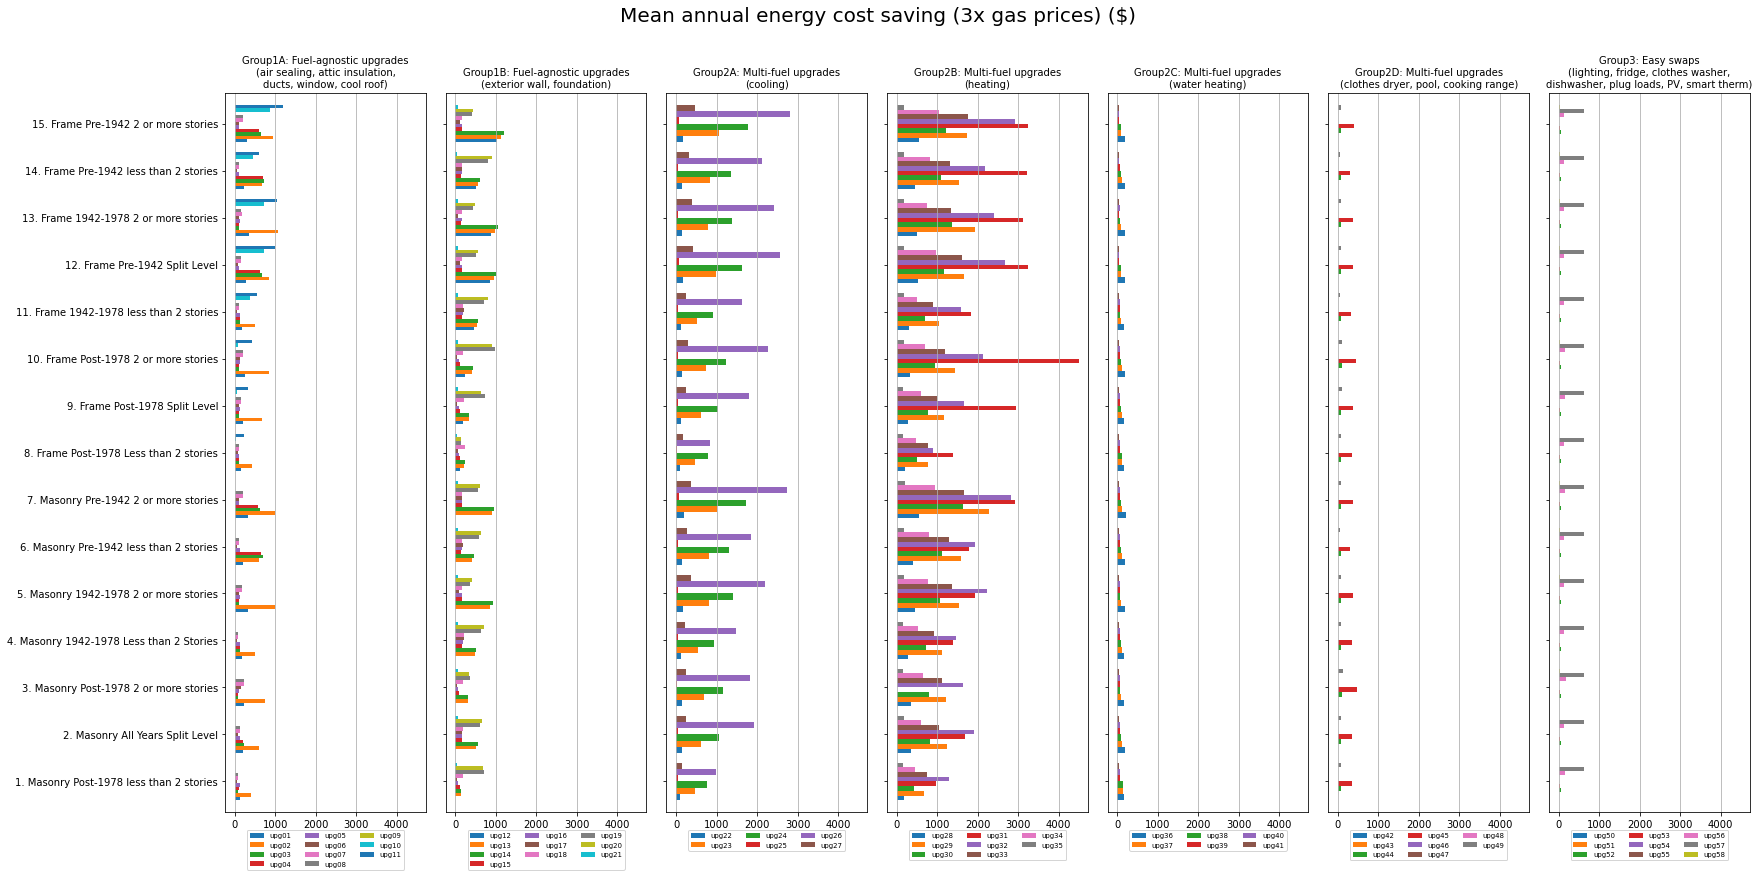

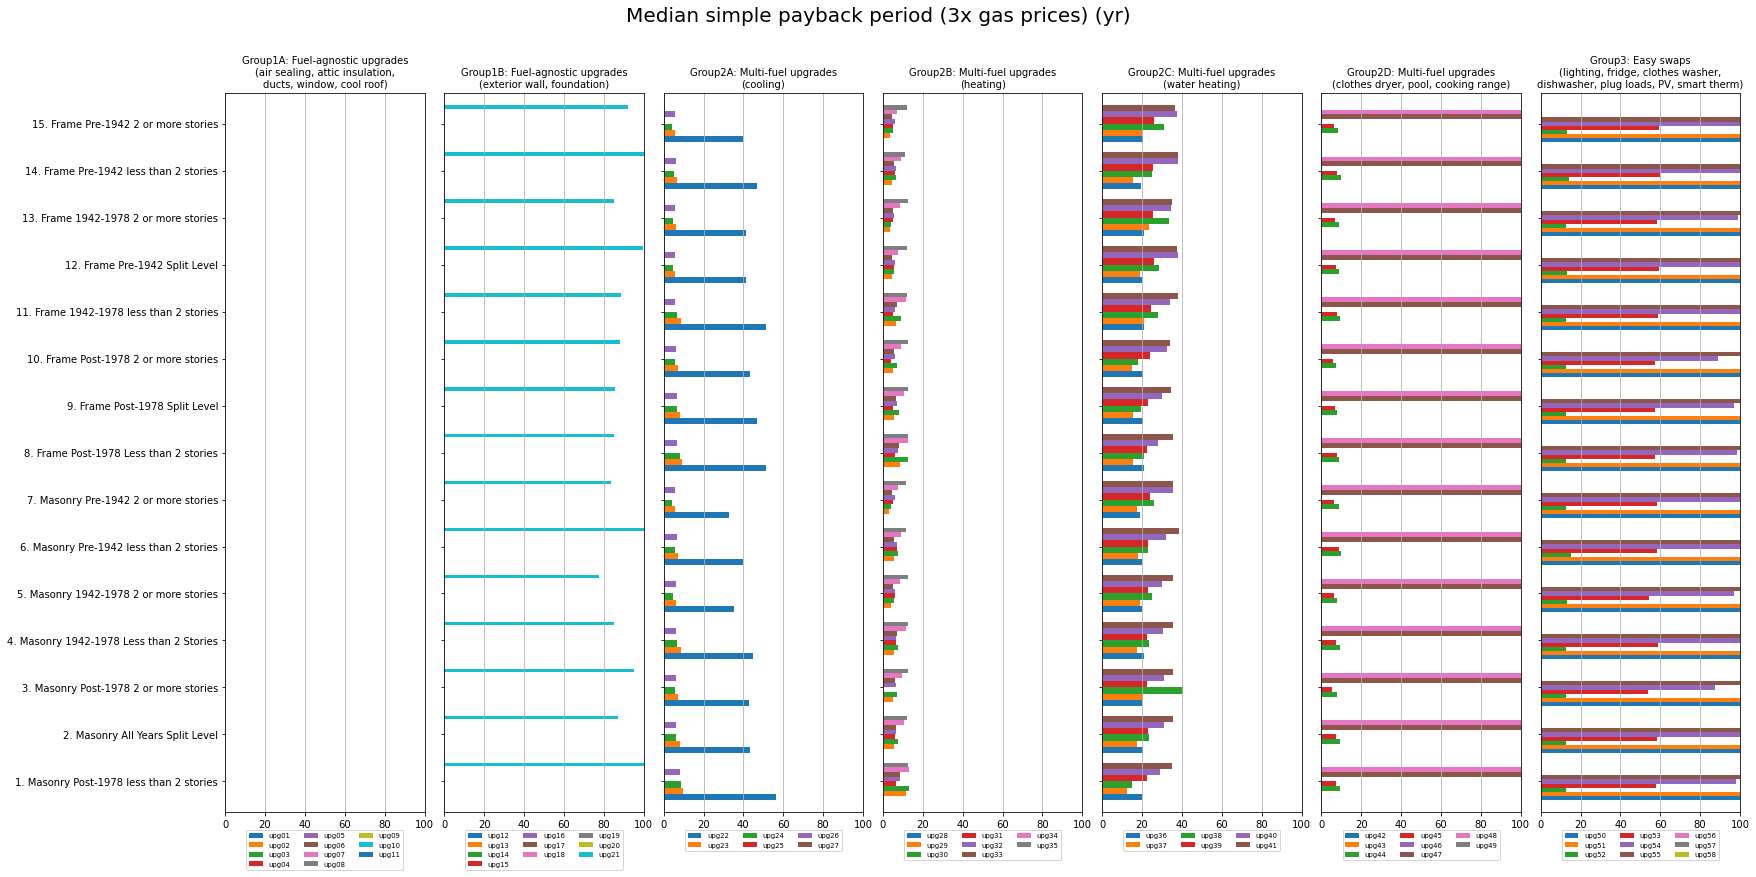

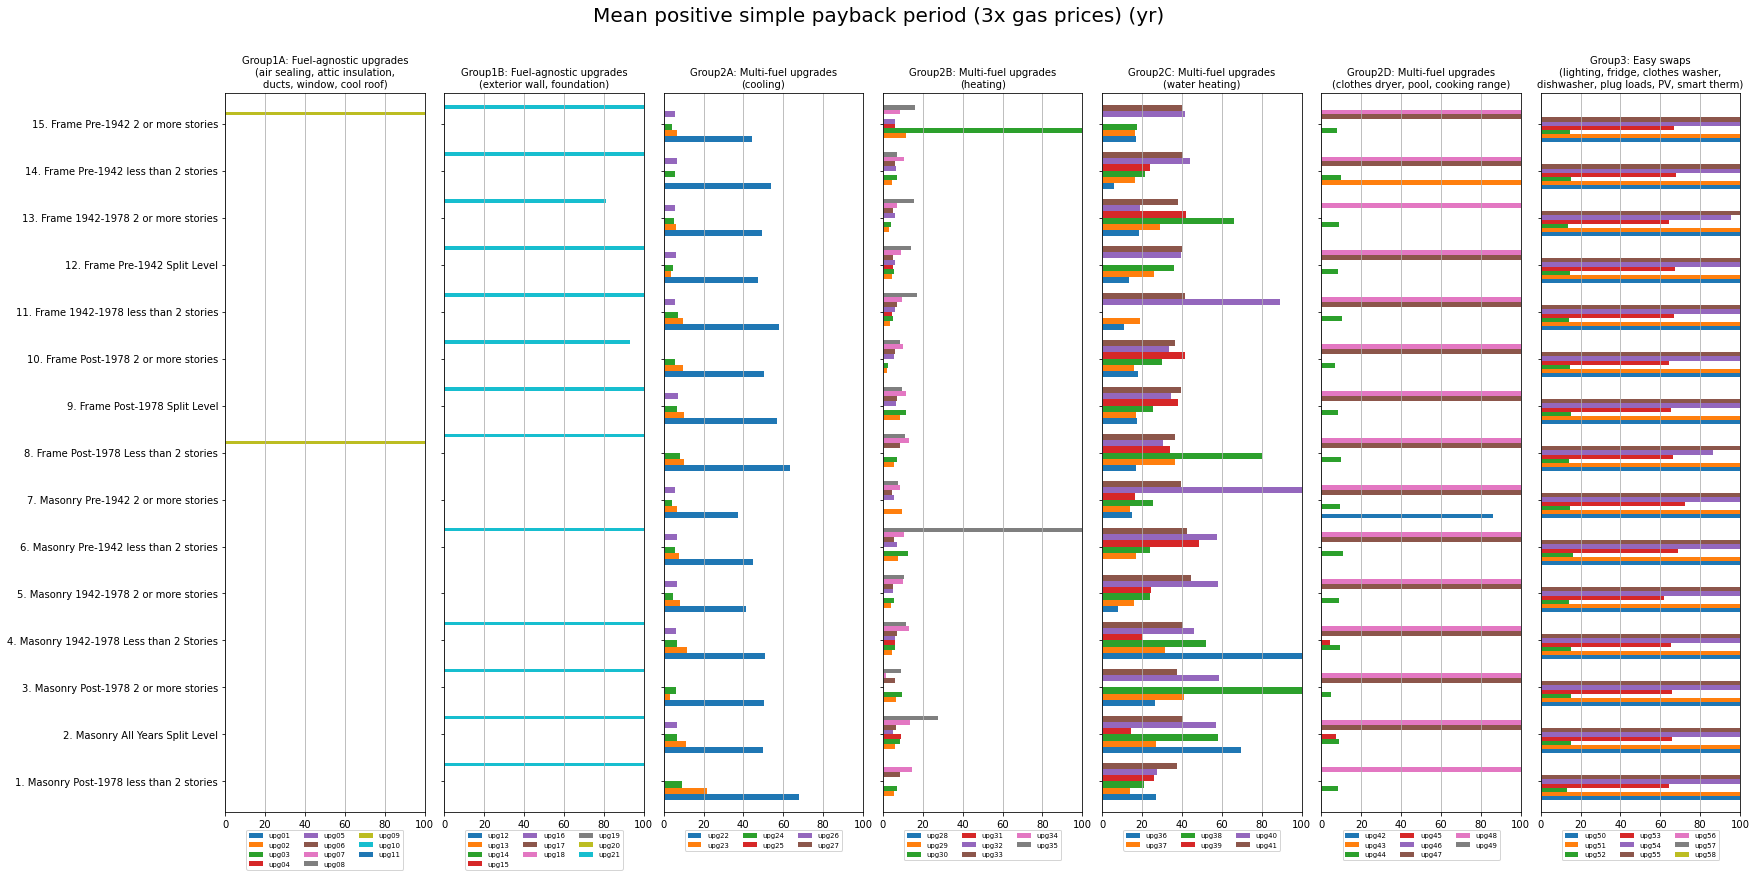

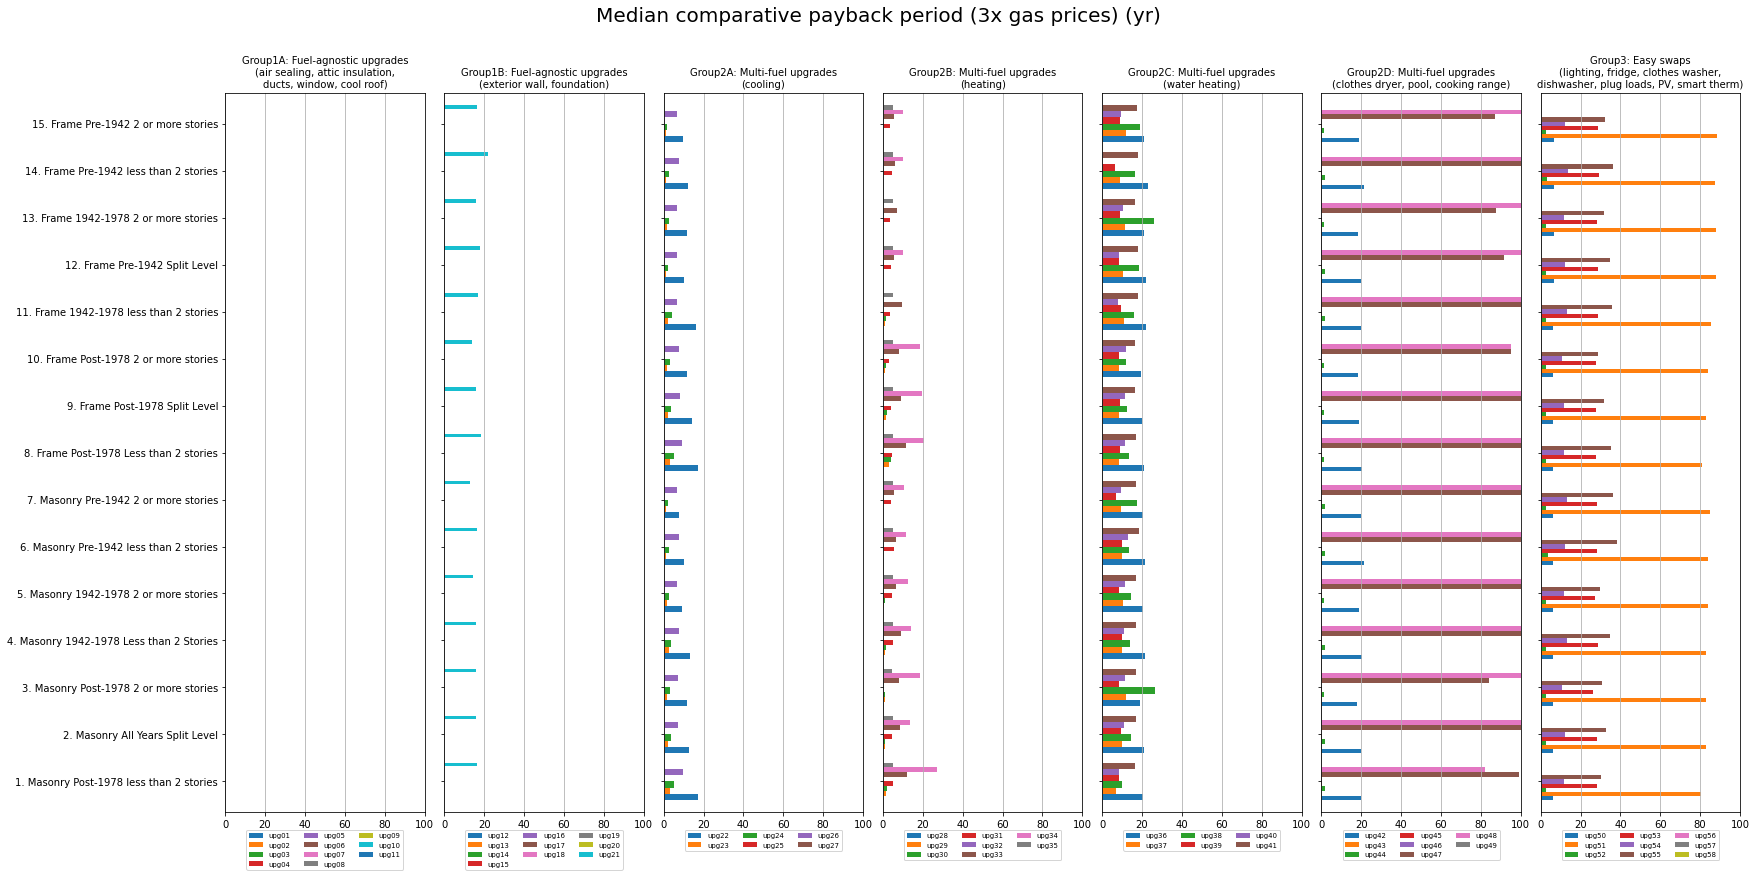

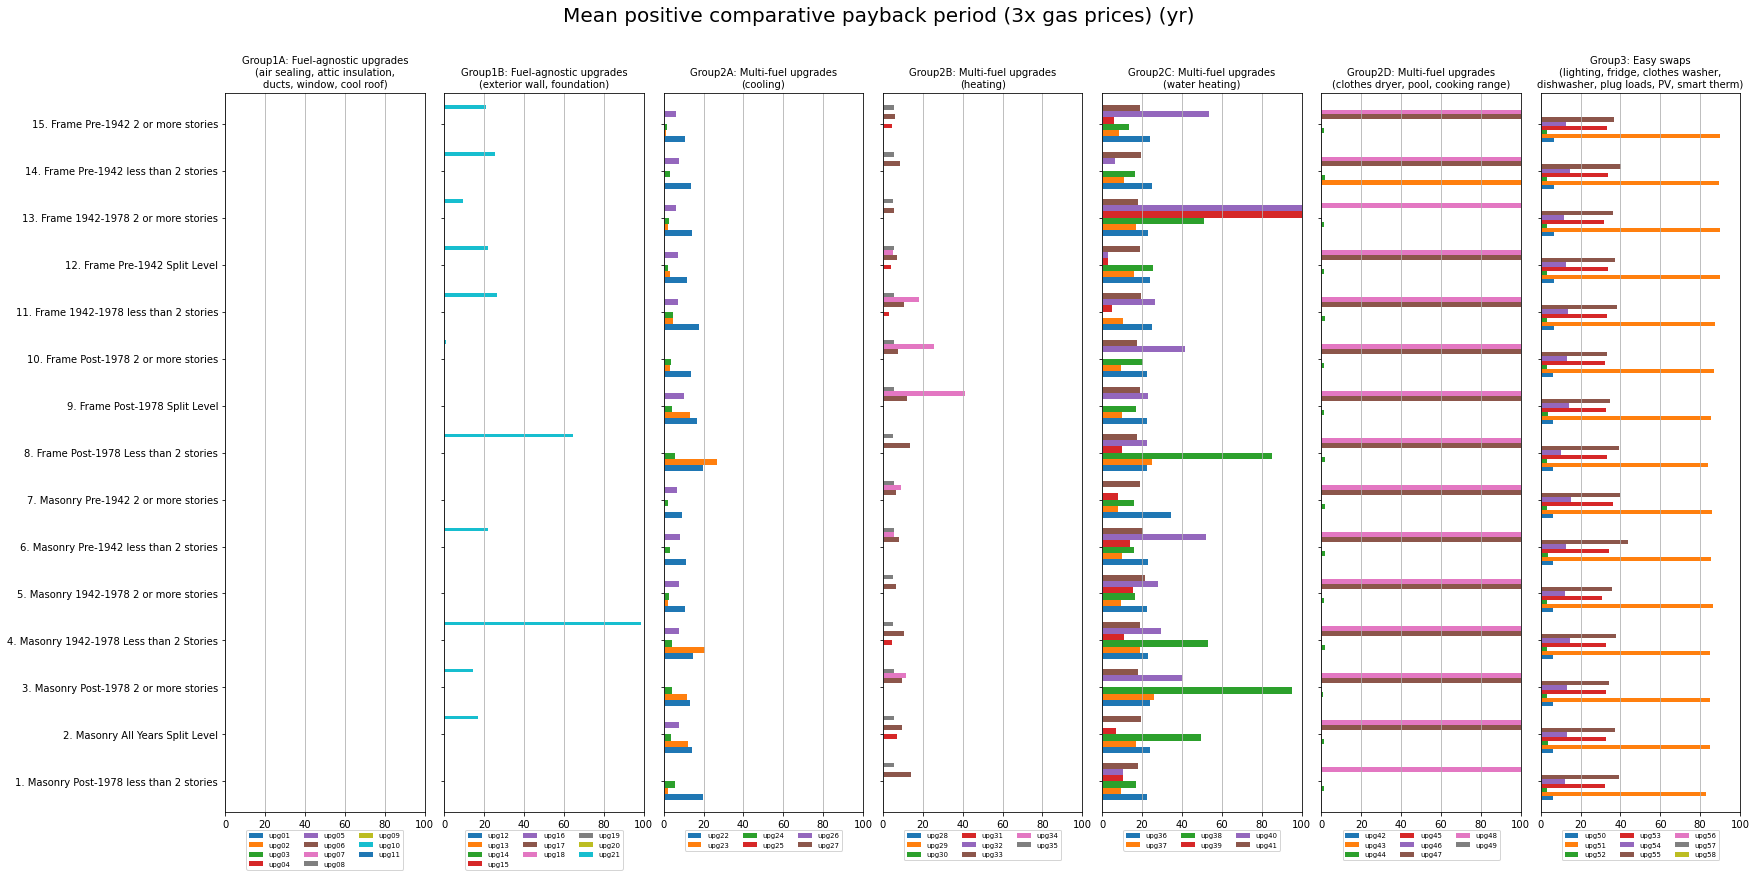

In [35]:
### plot mean values by sfd prototypes ###

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
    'median_simple_payback': [-70, 70],
    'median_comparative_payback': [-70, 70],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_sfd_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)', # filtered
        'median_comparative_payback': f'Median comparative payback period{title_ext} (yr)',
        'mean_pos_comparative_payback': f'Mean positive comparative payback period{title_ext} (yr)', # filtered
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)', # filtered
        'median_comparative_payback': f'Median comparative payback period{title_ext} (yr)',
        'mean_pos_comparative_payback': f'Mean positive comparative payback period{title_ext} (yr)', # filtered
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'

    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPs = groups2.set_index(idx)[para_to_plot]
    xmin = UPs.replace([np.inf, -np.inf], np.nan).min().min()*1.05
    xmax = UPs.replace([np.inf, -np.inf], np.nan).max().max()*1.05
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(ncols=7, nrows=1, 
                                                            sharex=True, sharey=True, figsize=(3.5*7, 12))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg20)
    # Group 1A: (upg01-upg10) N=10
    ax = ax1
    Name = 'Group1A: Fuel-agnostic upgrades\n(air sealing, attic insulation,\nducts, window, cool roof)'
    UPi = UPs.iloc[:, :11] 
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 1B: (upg11-upg20) N=10
    ax = ax2
    Name = 'Group1B: Fuel-agnostic upgrades\n(exterior wall, foundation)'
    UPi = UPs.iloc[:, 11:21]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    
    ### Group 2: Multi-fuel upgrades (upg21-upg48)
    # Group 2A: (upg21-upg26) N=6
    ax = ax3
    Name = 'Group2A: Multi-fuel upgrades\n(cooling)'
    UPi = UPs.iloc[:, 21:27]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2B: (upg27-upg34) N=8
    ax = ax4
    Name = 'Group2B: Multi-fuel upgrades\n(heating)'
    UPi = UPs.iloc[:, 27:35]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2C: (upg35-upg40) N=6
    ax = ax5
    Name = 'Group2C: Multi-fuel upgrades\n(water heating)'
    UPi = UPs.iloc[:, 35:41]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2D: (upg41-upg48) N=8
    ax = ax6
    Name = 'Group2D: Multi-fuel upgrades\n(clothes dryer, pool, cooking range)'
    UPi = UPs.iloc[:, 41:49]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)


    ### Group 3: Easy swaps (upg49-upg58) N=9
    ax = ax7
    Name = 'Group3: Easy swaps\n(lighting, fridge, clothes washer,\ndishwasher, plug loads, PV, smart therm)'
    UPi = UPs.iloc[:, 49:]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'mean_pos_simple_payback', 
                        'median_comparative_payback','mean_pos_comparative_payback']:
        ax.set_xlim(0,100)
    
    fig.suptitle(para_label, fontsize=20, y=1.01)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    
    filename = f'{iter_path}-comparison_{para_to_plot}{zoom_ext}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [36]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades.loc[~summary_upgrades['upgrade_no'].isnull(), ['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
groups_avg


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,1,"Air Leakage 25% Reduction, with Mech Vent unde...",339.530,189.120,255.340,145.600,206.680,303.610,277.820,225.550,314.460,188.370,210.690,216.130,127.710,314.460,208.590,236.152963
1,mean_ann_energy_cost_saving,2,"Air Leakage to 1ACH50, with Mech Vent",1074.540,506.150,853.620,423.220,663.180,950.380,855.230,662.380,993.920,502.820,608.990,750.660,400.640,986.300,608.240,726.130219
2,mean_ann_energy_cost_saving,3,"Attic Insulation, R-49",97.640,128.370,94.830,91.260,93.240,644.480,673.180,730.740,107.480,131.750,217.500,74.290,88.080,625.380,688.750,368.160840
3,mean_ann_energy_cost_saving,4,"Attic Insulation, R-60",101.270,134.480,106.450,103.840,105.290,603.060,631.840,690.170,111.780,135.210,212.810,81.230,97.460,578.670,647.810,351.656576
4,mean_ann_energy_cost_saving,5,"Duct Sealing and Insulation to R-8, 10% Leakage",138.730,131.250,139.750,105.370,124.180,105.770,107.300,110.560,131.330,138.490,130.780,112.820,119.020,111.000,125.210,114.837237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,pct_pos_simple_payback,51,"EnergyStar Refrigerator, Most Eff",99.912,99.834,99.867,99.832,99.926,99.930,99.906,99.858,99.874,99.800,99.847,99.805,99.854,99.891,99.862,99.875193
588,pct_pos_simple_payback,52,EnergyStar Clothes Washer,37.065,35.714,38.095,38.942,35.435,35.281,36.657,38.000,37.729,33.883,34.321,37.500,37.705,37.261,37.838,36.923712
589,pct_pos_simple_payback,53,"EnergyStar Clothes Washer, Most Eff",97.048,97.591,96.589,96.226,97.188,97.290,97.799,96.512,96.667,97.675,97.698,96.055,96.444,96.781,96.624,96.876468
590,pct_pos_simple_payback,54,EnergyStar Dishwasher,13.065,17.155,12.230,11.607,12.749,13.406,15.736,11.864,11.972,16.081,17.391,12.644,11.538,11.644,11.667,12.867115


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results/plots/mean_values_sfd_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: median_simple_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_pos_simple_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: median_comparative_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Chicago avg: mean_pos_comparative_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3


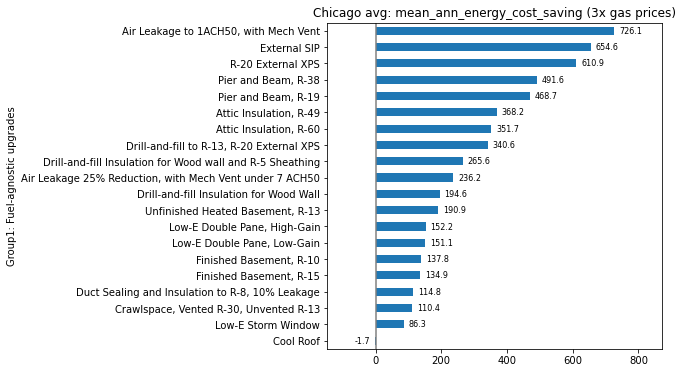

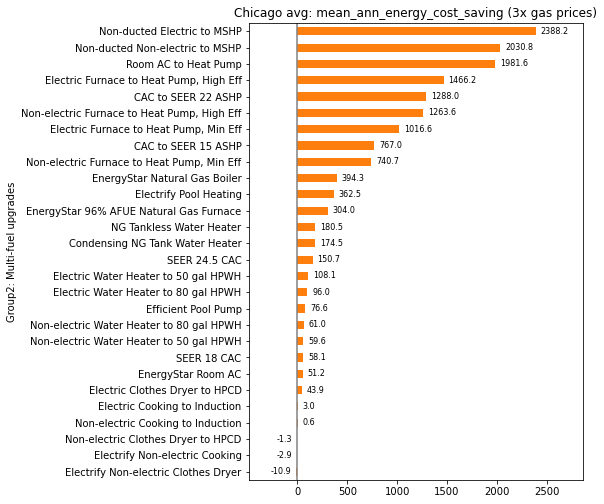

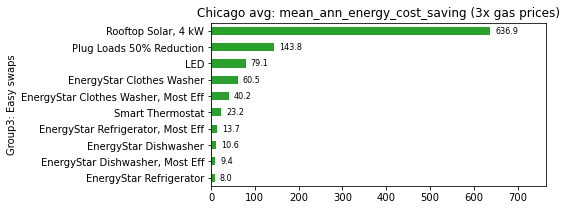

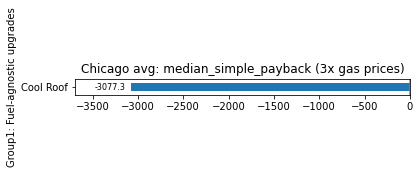

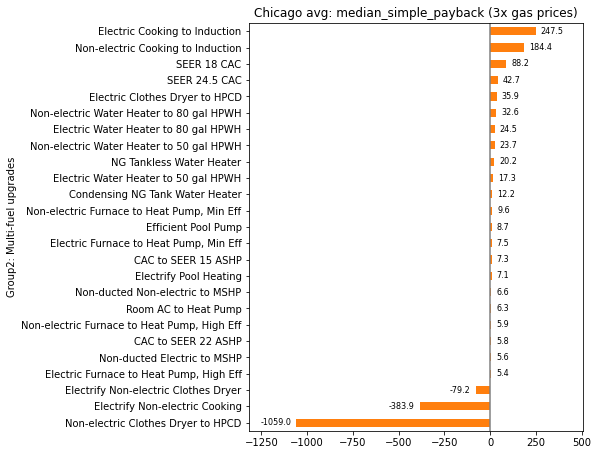

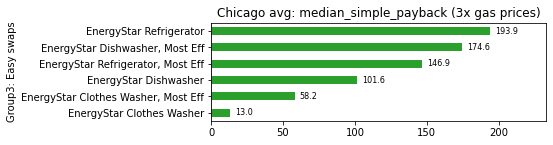

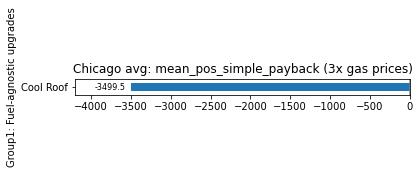

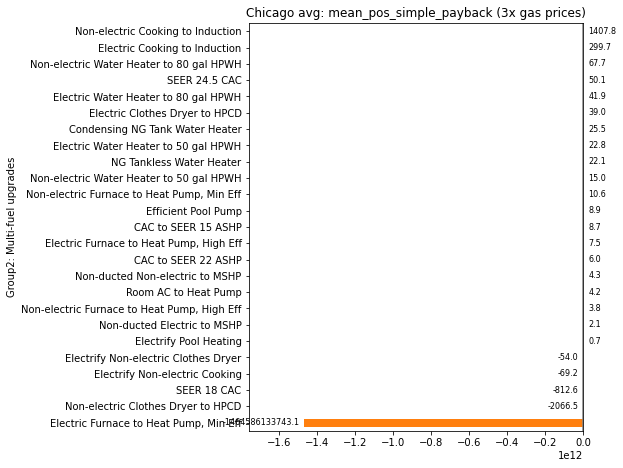

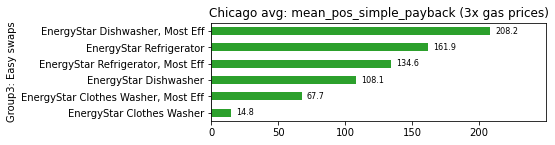

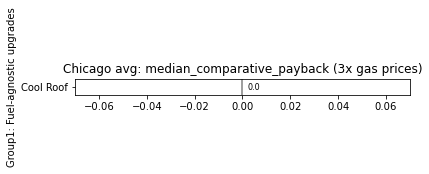

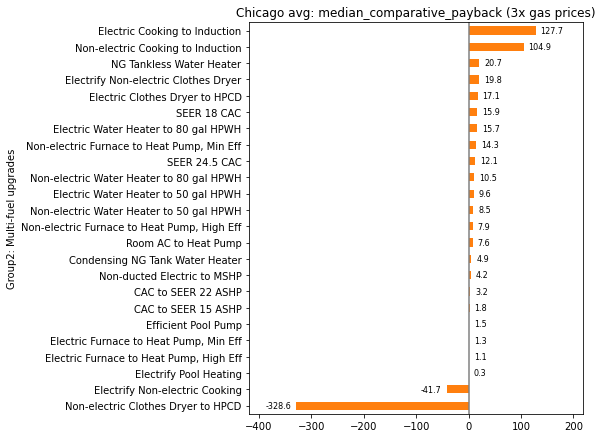

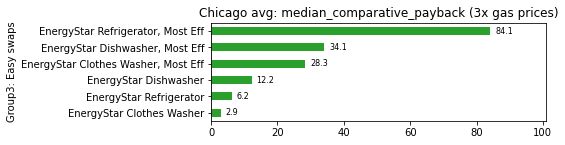

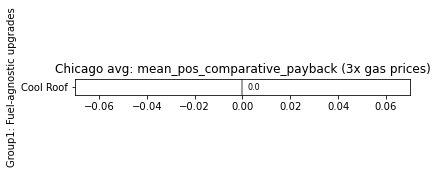

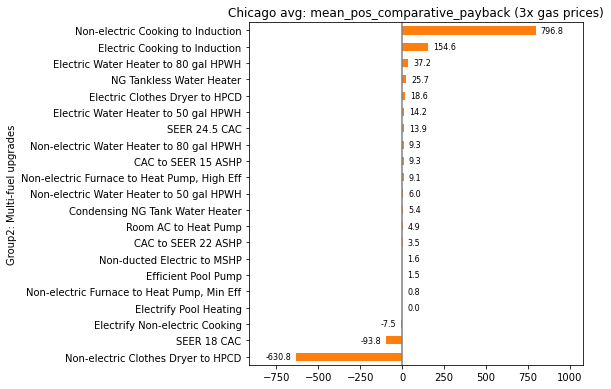

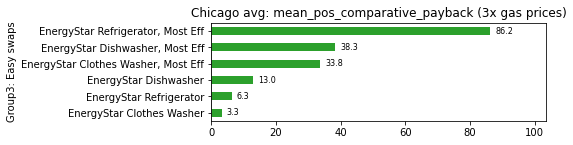

In [37]:
### plot Chicago-weighted avg from sfd prototypes ###

para_to_plot = 'Chicago avg' # <------

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 21),
    'Group2: Multi-fuel upgrades': range(21, 49),
    'Group3: Easy swaps': range(49, 59),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_sfd_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 
                       'median_simple_payback', 
                       'mean_pos_simple_payback', # filtered
                       'median_comparative_payback', 
                       'mean_pos_comparative_payback'] # filtered
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name')
        if metric in ['median_simple_payback', 'mean_pos_simple_payback',
                       'median_comparative_payback', 'mean_pos_comparative_payback']:
            groupi = groupi.replace(0,np.nan).sort_values(by = para_to_plot) # make 0 nan
        else:
            groupi = groupi.sort_values(by = para_to_plot)
            
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.3. plot mean values for Chicago total stock 
Run cell below to load df for plots

In [ ]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    groups_total = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_chicago_total_{fn_ext}.csv'),
                         header=[0])
    
    print(f'"groups_total{fn_ext}" df loaded from file.')
    display(groups_total)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results/plots/sum_values_sfd_chicago_total

Plotting Chicago total ann_gas_cost_saving (3x gas prices)...
    - Group1
    - Group2
    - Group3


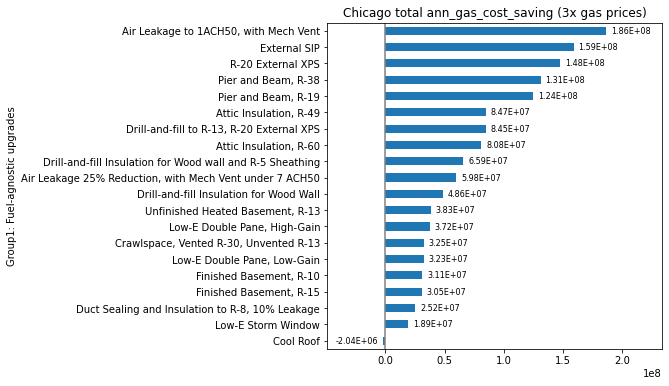

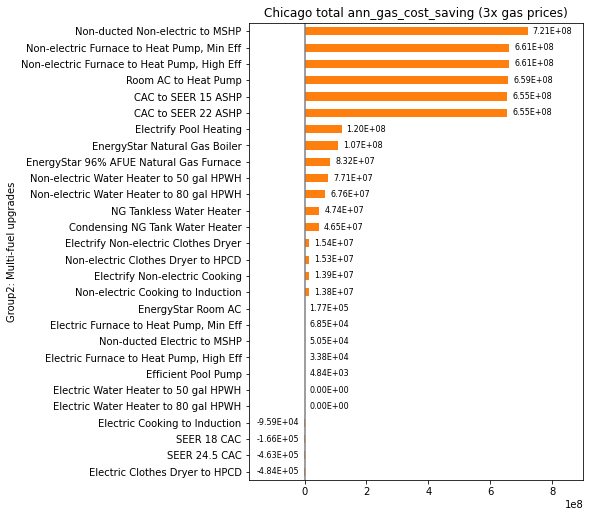

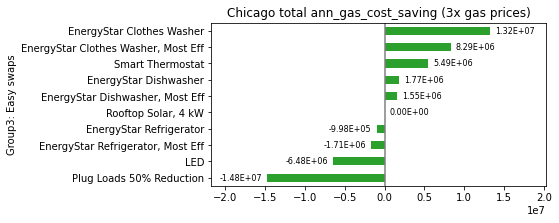

In [40]:
### plot Chicago total from sfd prototypes ###

para_to_plot = 'Chicago total' # <------

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 21),
    'Group2: Multi-fuel upgrades': range(21, 49),
    'Group3: Easy swaps': range(49, 59),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:
plot_path3 = os.path.join(plot_path, 'sum_values_sfd_chicago_total')
if not os.path.exists(plot_path3):
    os.mkdir(plot_path3)
print(f'plot dir: {plot_path3}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_total['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_gas_cost_saving']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot} {metric[5:]}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_total[(groups_total['metrics']==metric) & 
                              (groups_total['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.2E}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values.                      
                                            
        ax.margins(x=0.25)
        ax.axvline(x=0, linestyle='-', color='gray')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric[5:]}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path3, filename),
                    bbox_inches='tight')

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [ ]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    all_proto_upgrades = pd.read_csv(
        os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['upgrade_no'].nunique()
    print(f'   total number of upgrades: {N_upgrades}')
    
    display(all_proto_upgrades)
    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03/processed results/plots/distribution_by_sfd_prototype

>> 1. plotting ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting simple_payback_3x_gas_prices...


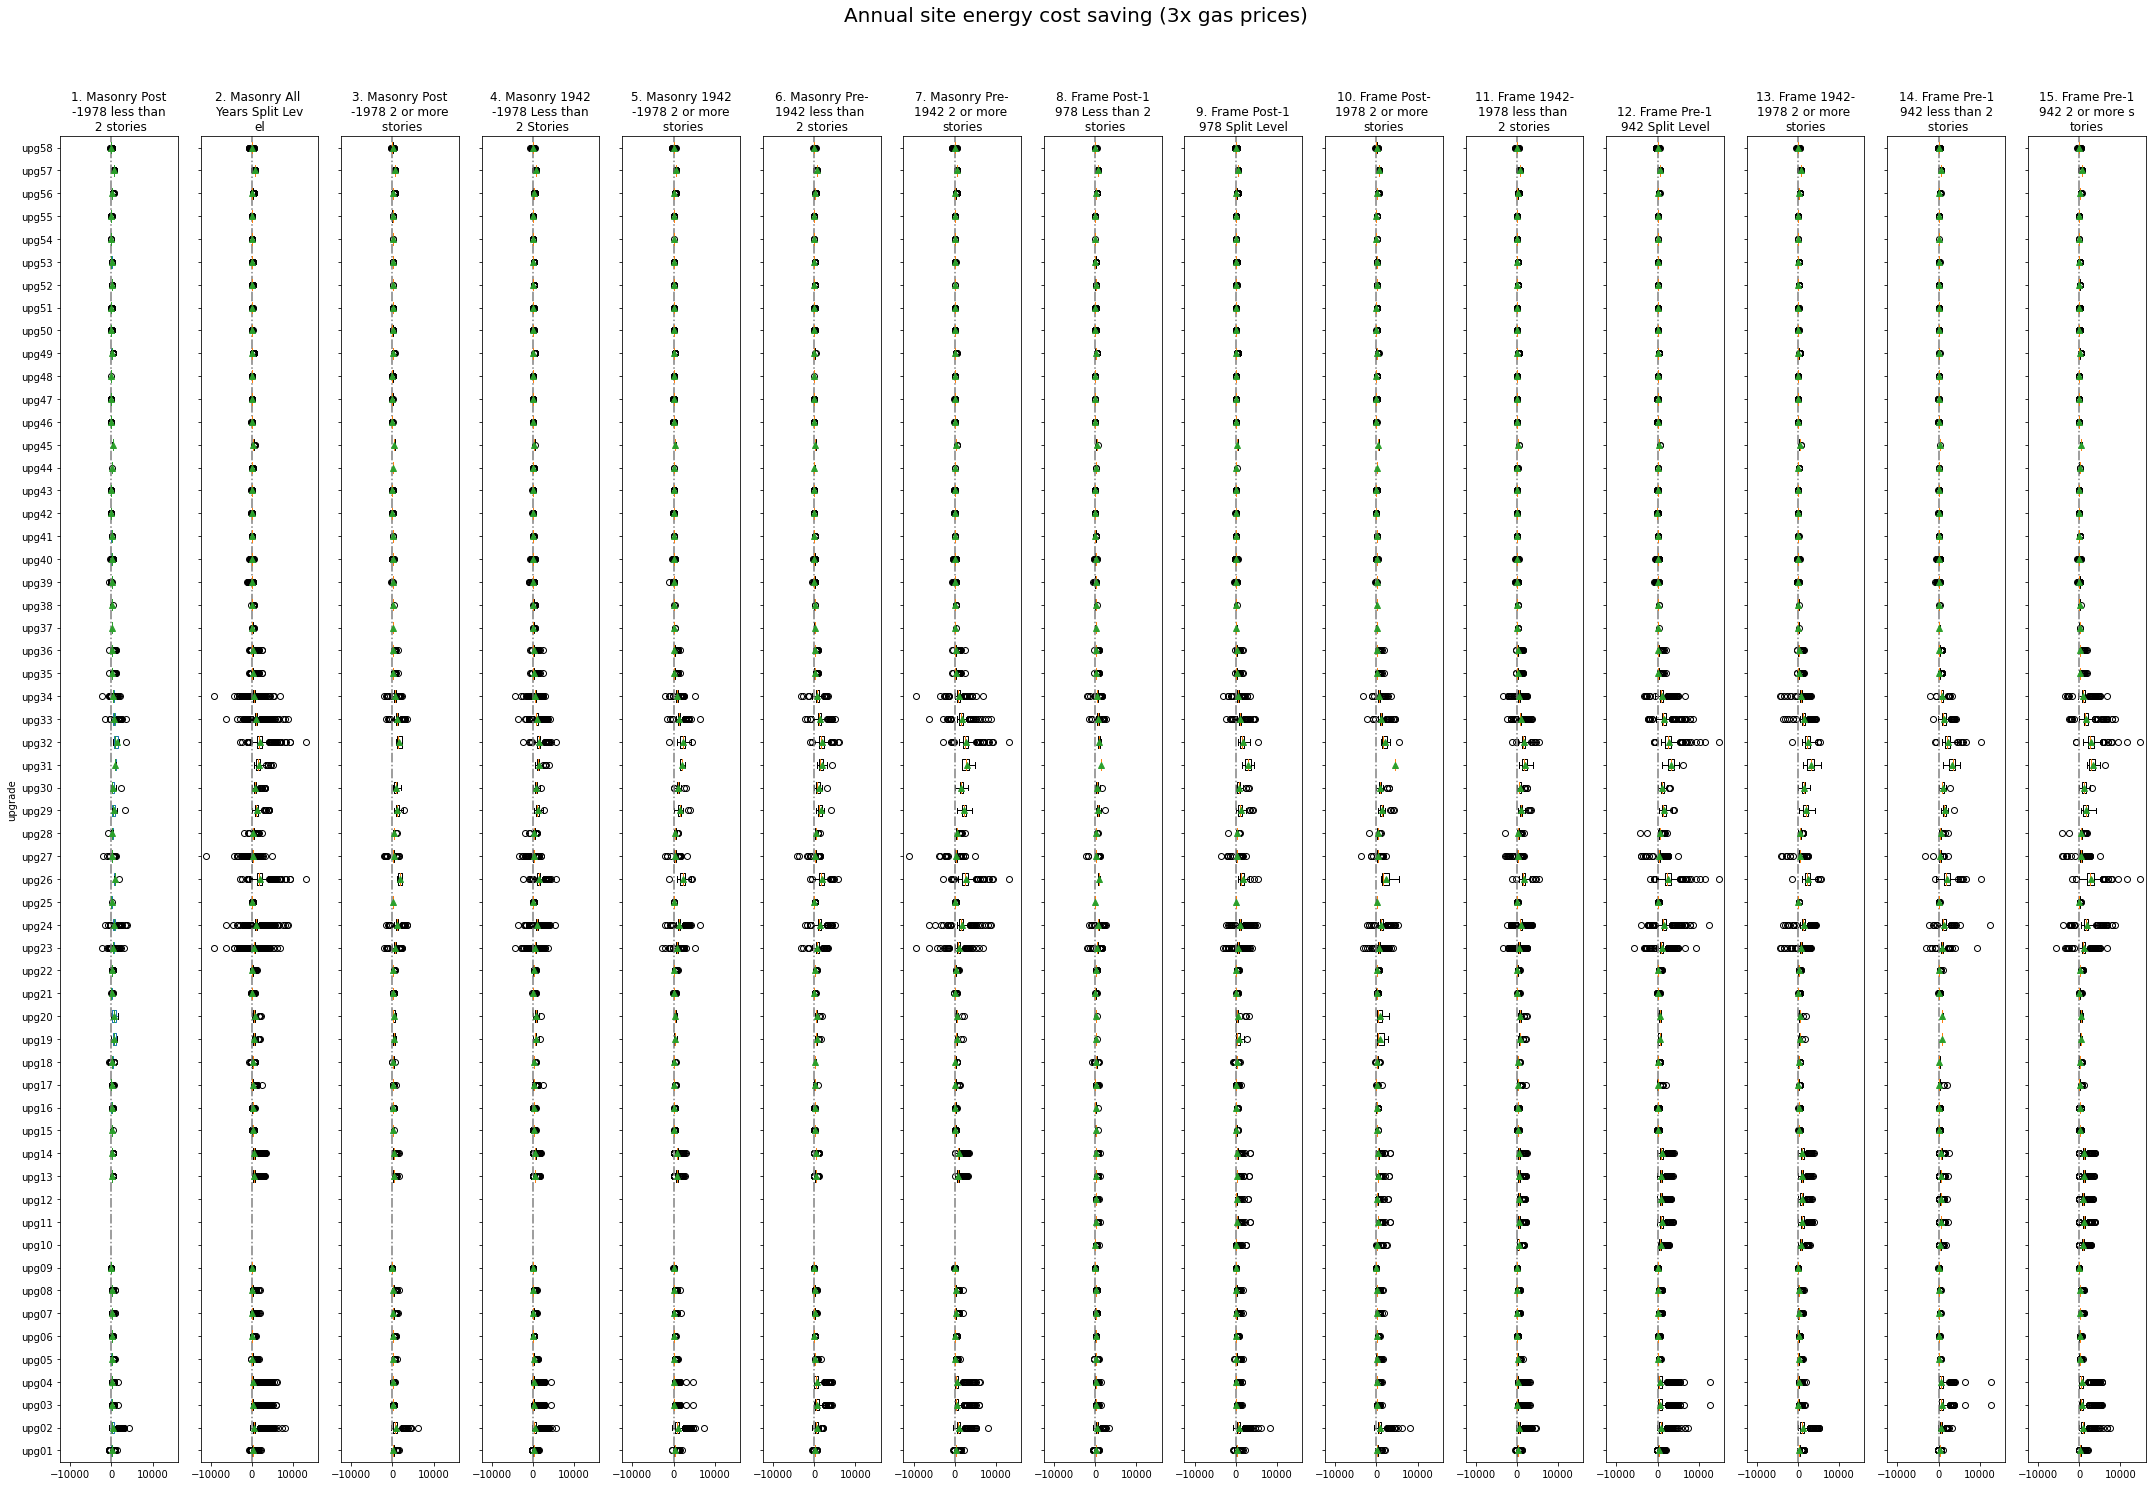

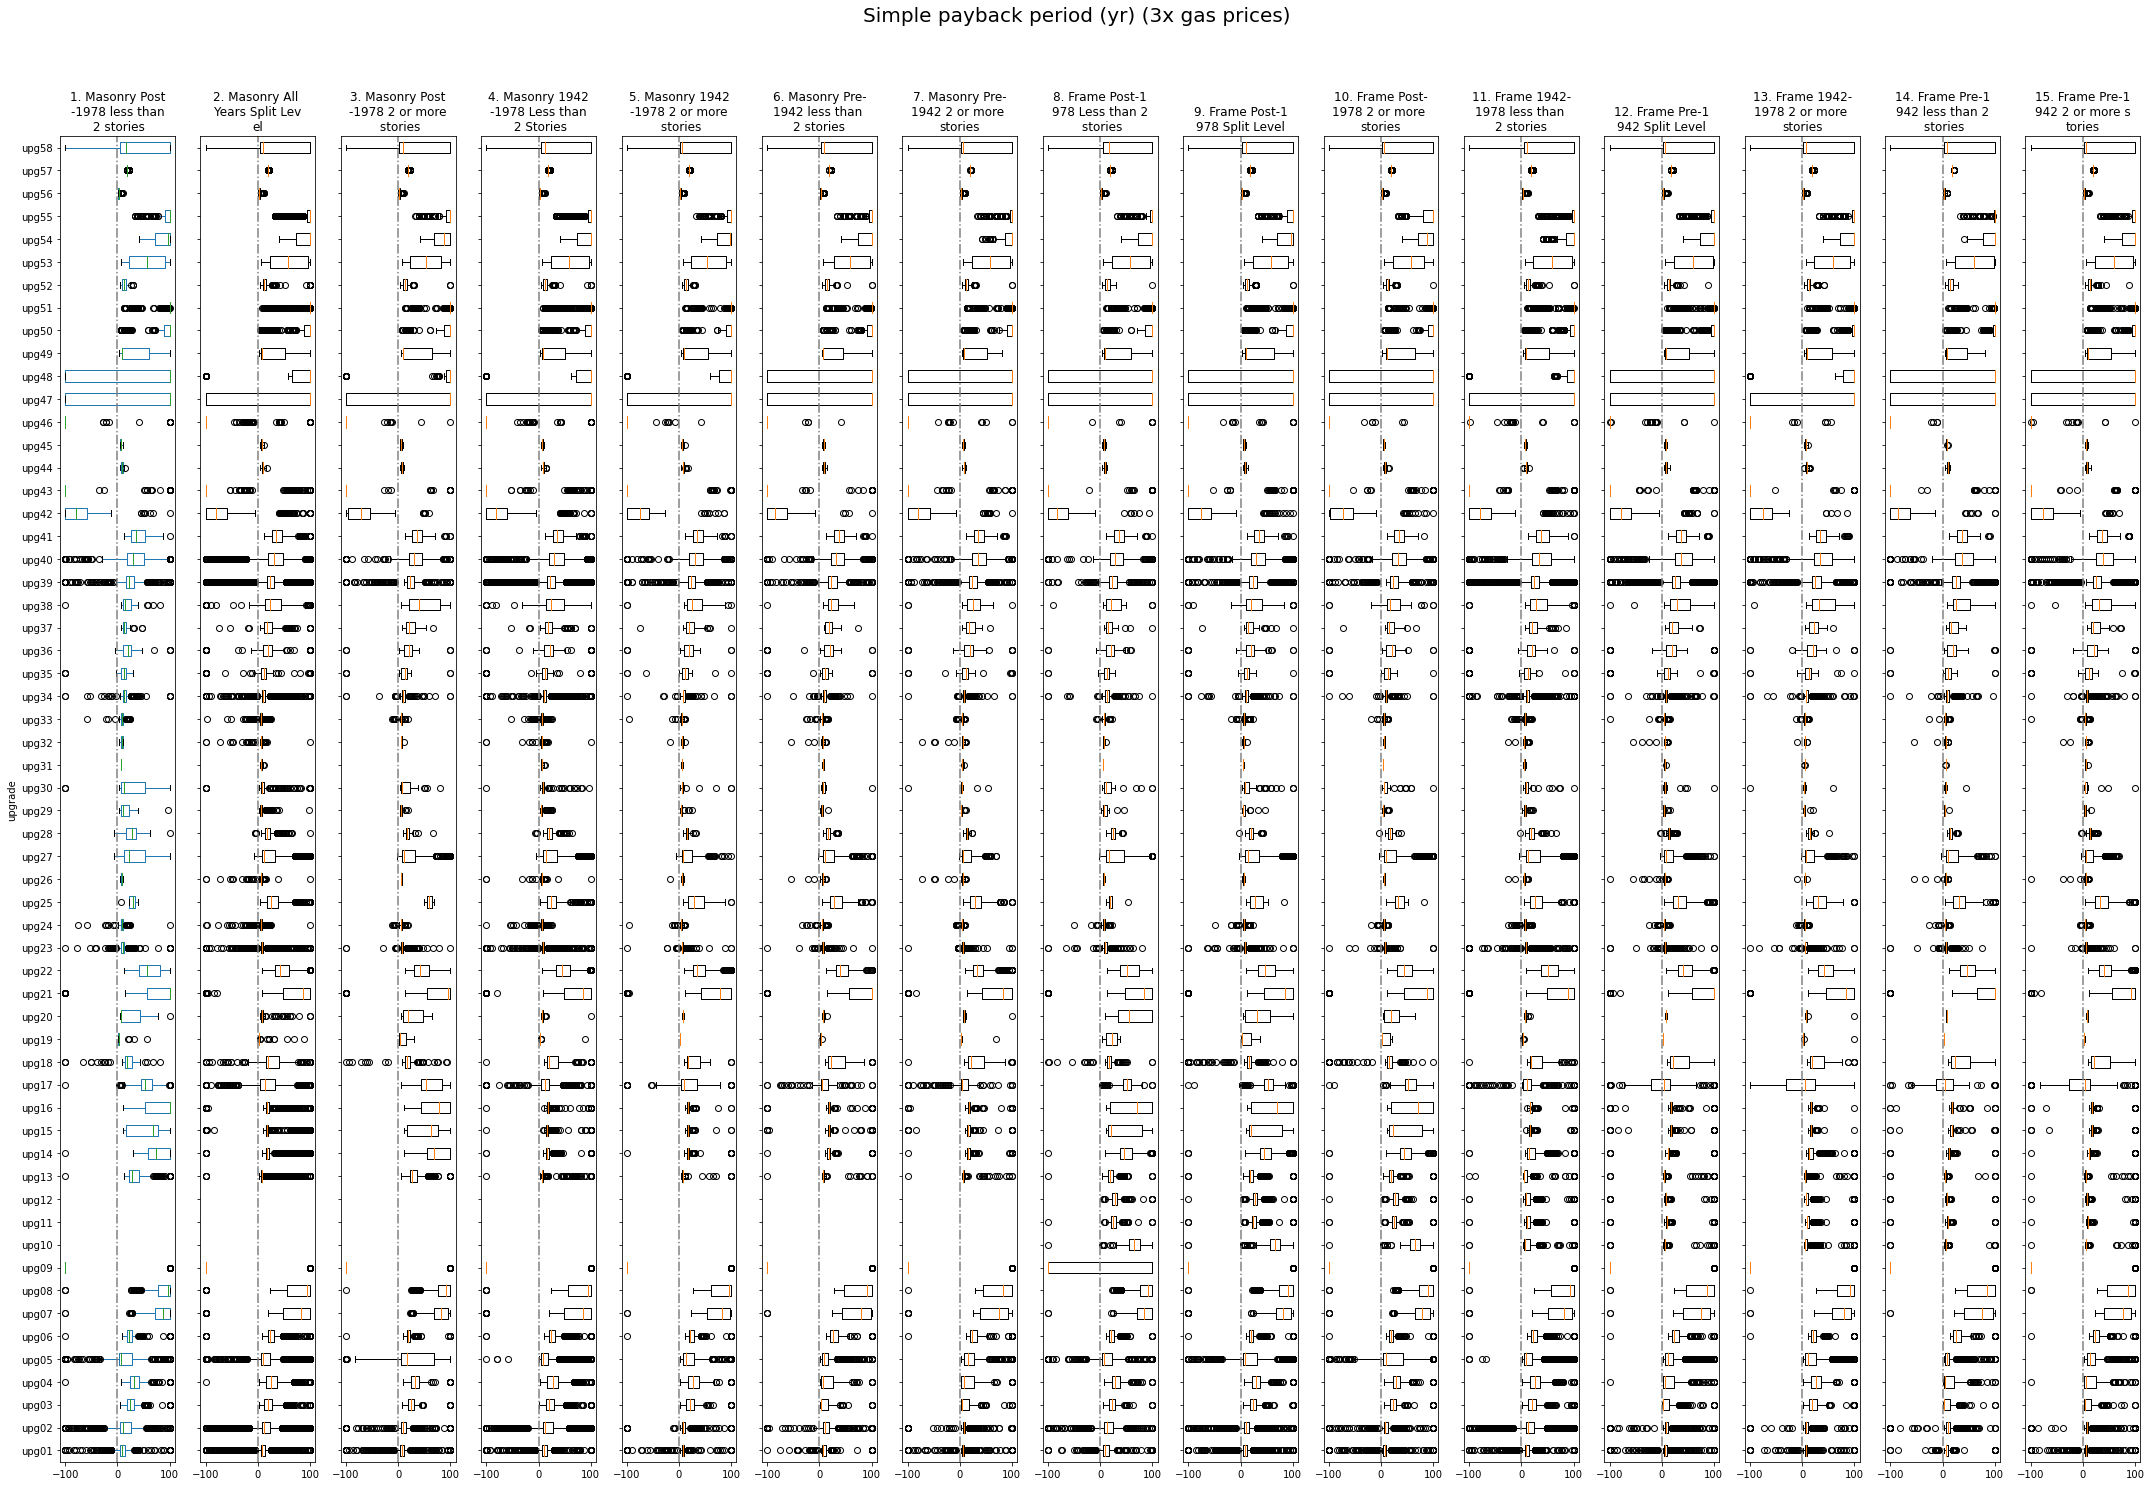

In [41]:
### plot metrics distribution ###

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_sfd_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

upgrades = list(upgrades_path_df['upgrade_no'].dropna(axis=0))
cols_to_match = list(f'upg{int(i):02d}' for i in upgrades)

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 20))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'upgrade_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'upgrade_no'] = 'upg'+p['upgrade_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='upgrade_no')
        p = p.set_index([p.index, 'upgrade_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')

        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1)
        
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('upgrade')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred') 
            
        ax.set_yticks(upgrades)
        ax.set_yticklabels(cols_to_match)
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')
